In [20]:
from herbie import Herbie, FastHerbie
import pandas as pd, numpy as np
import xarray as xr
import dask
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

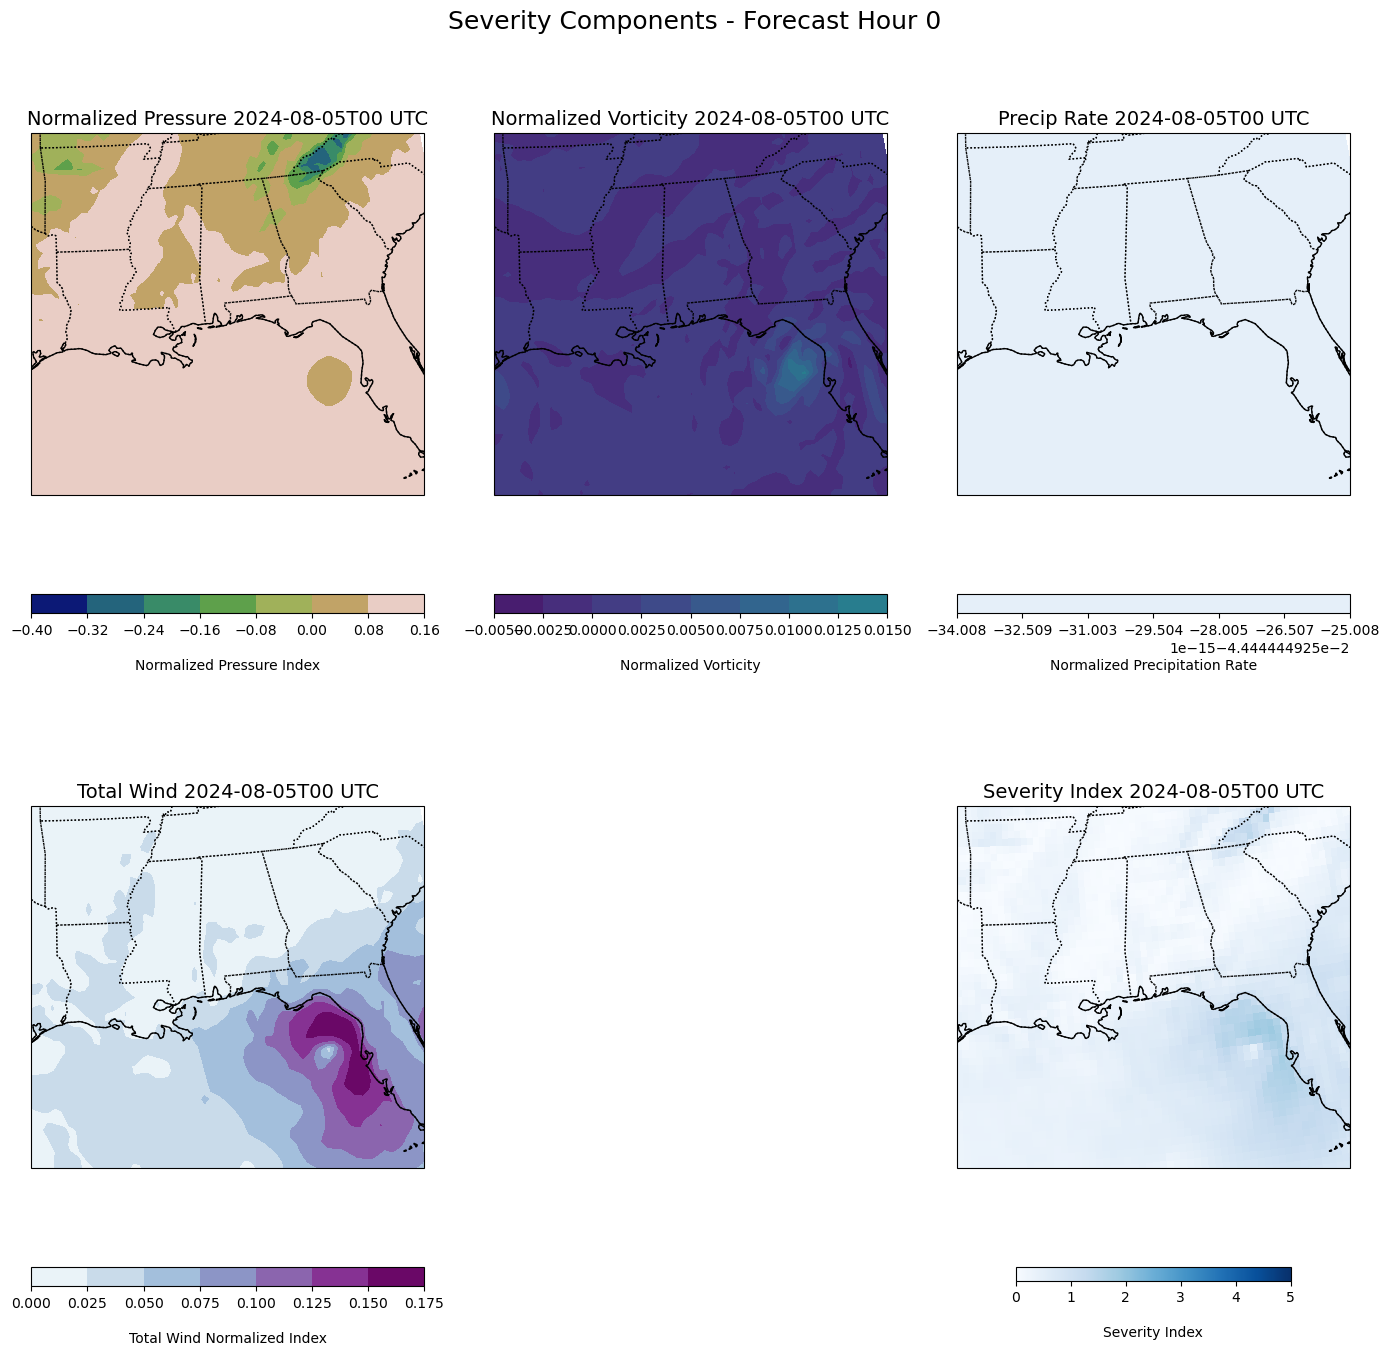

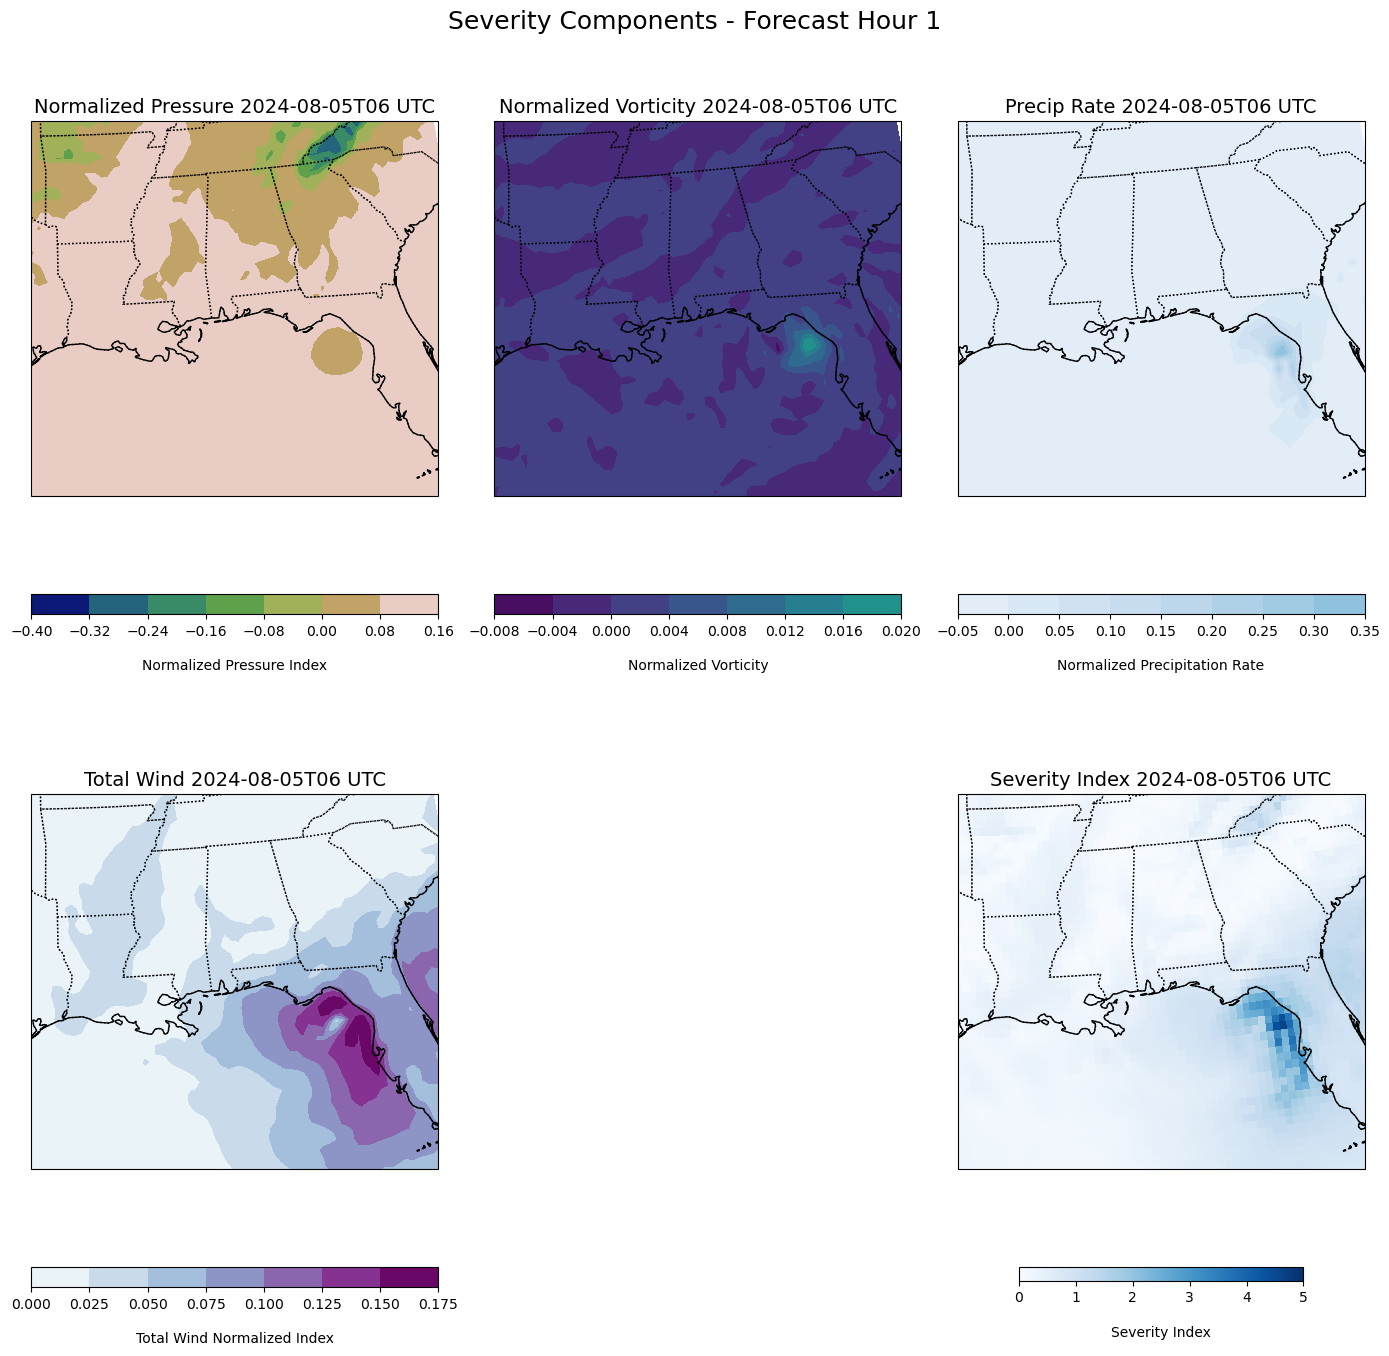

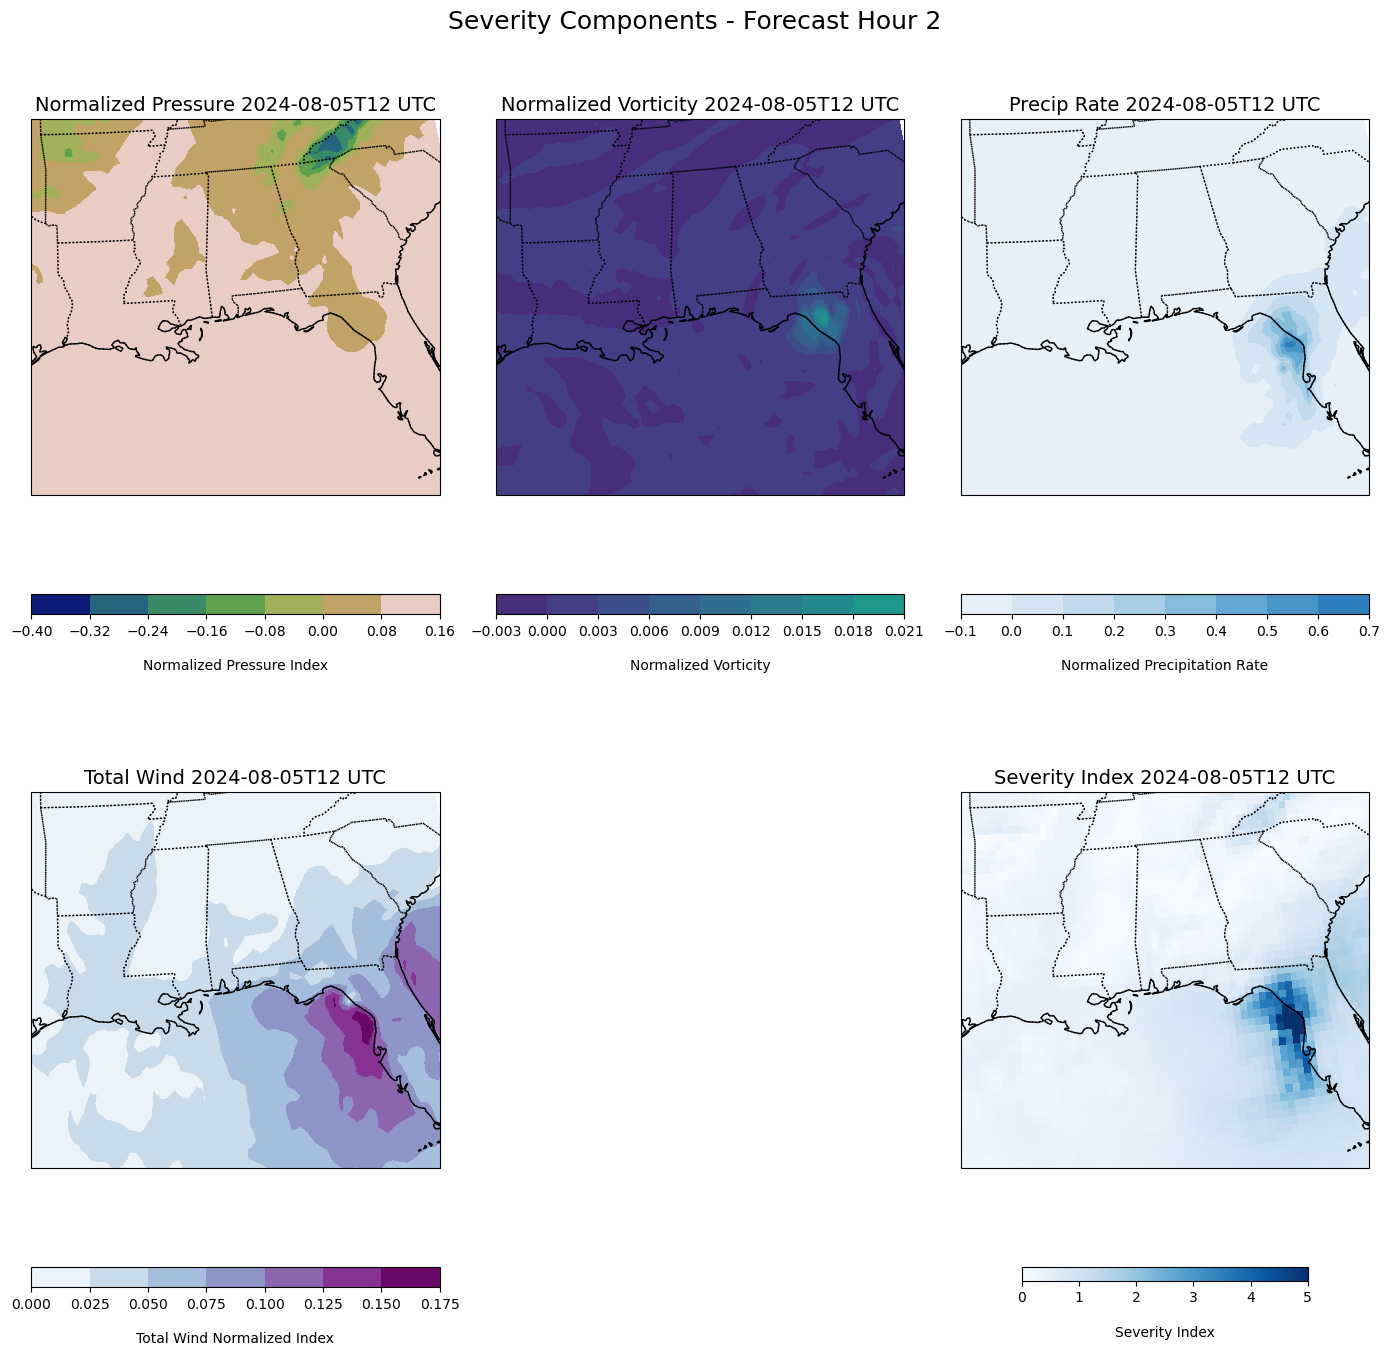

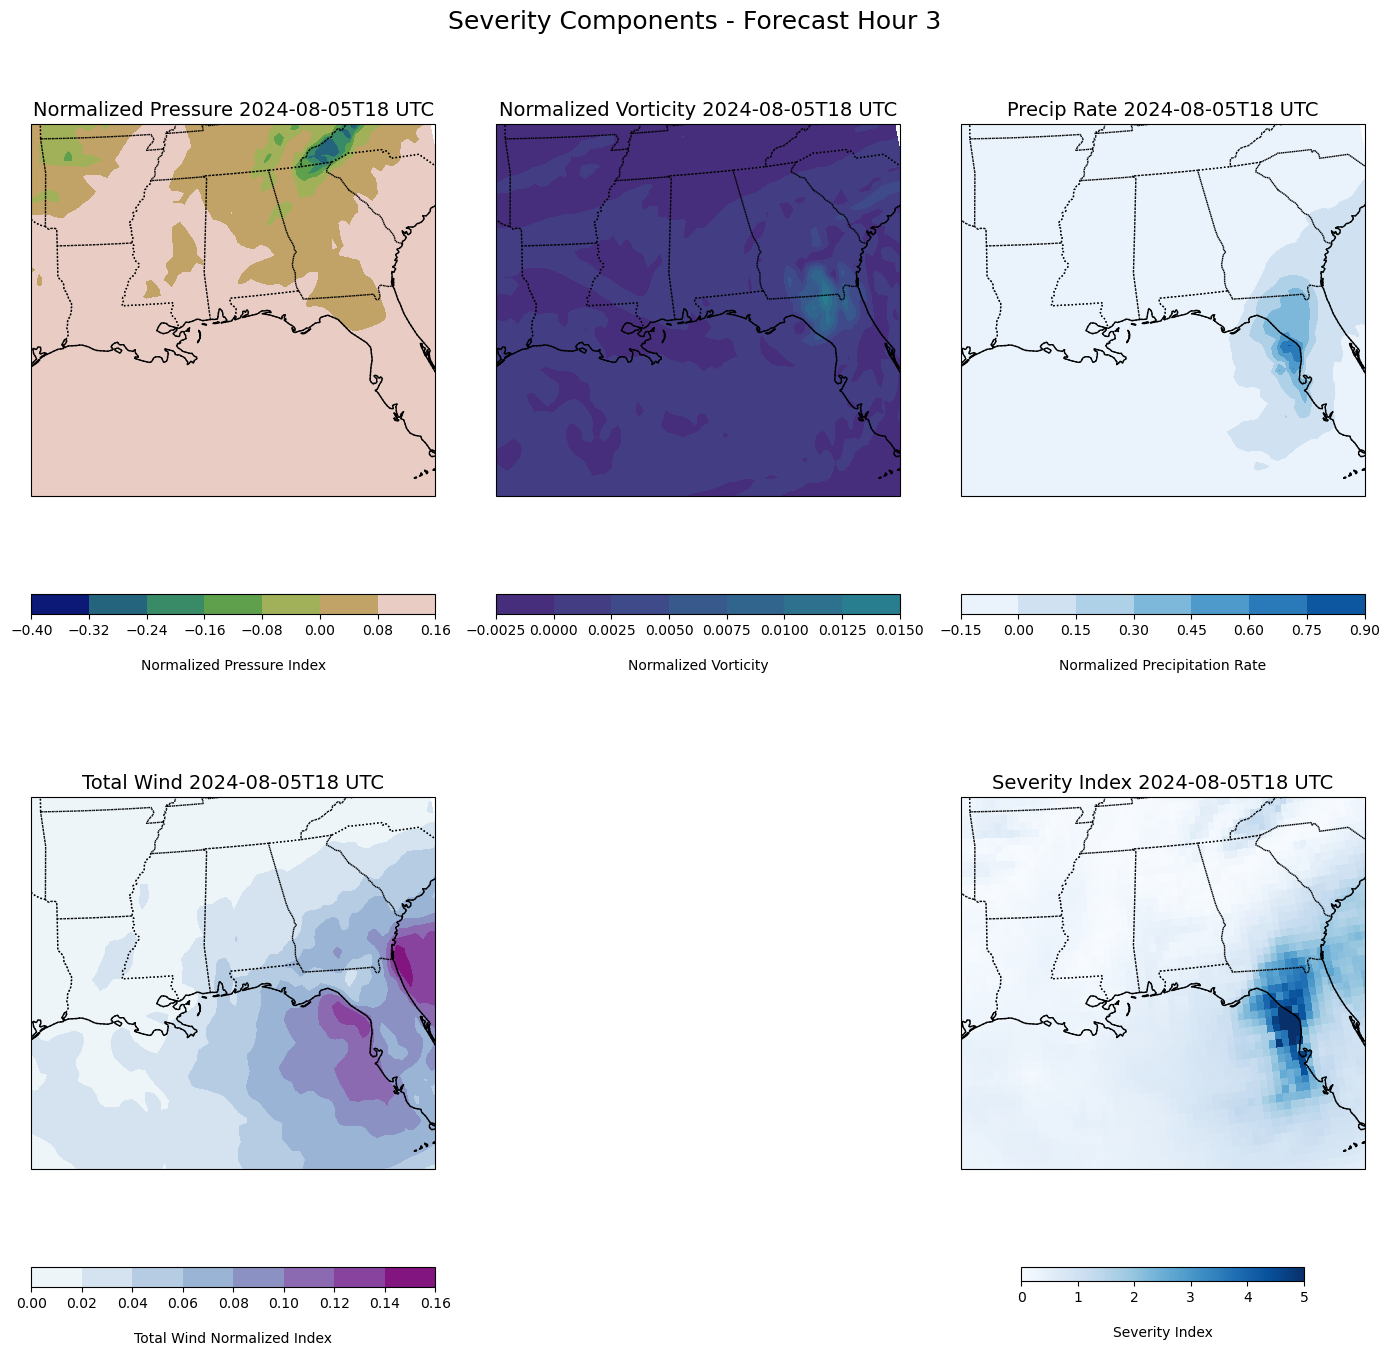

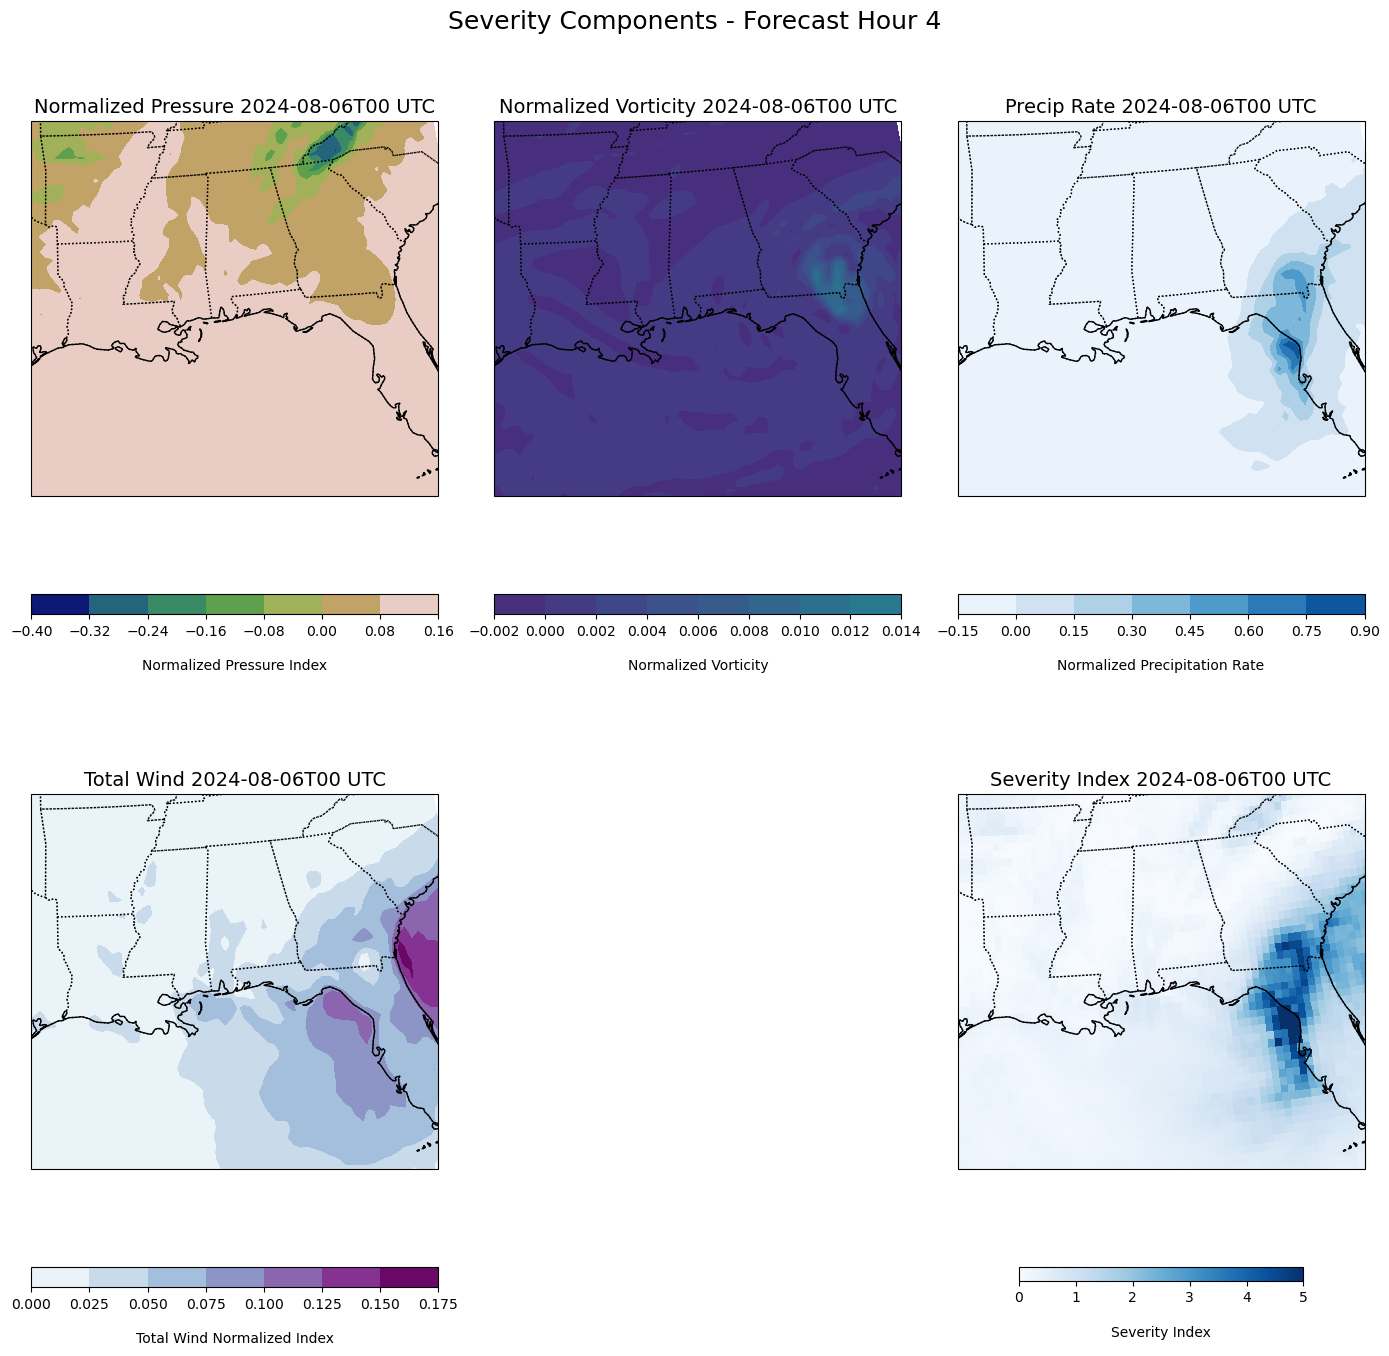

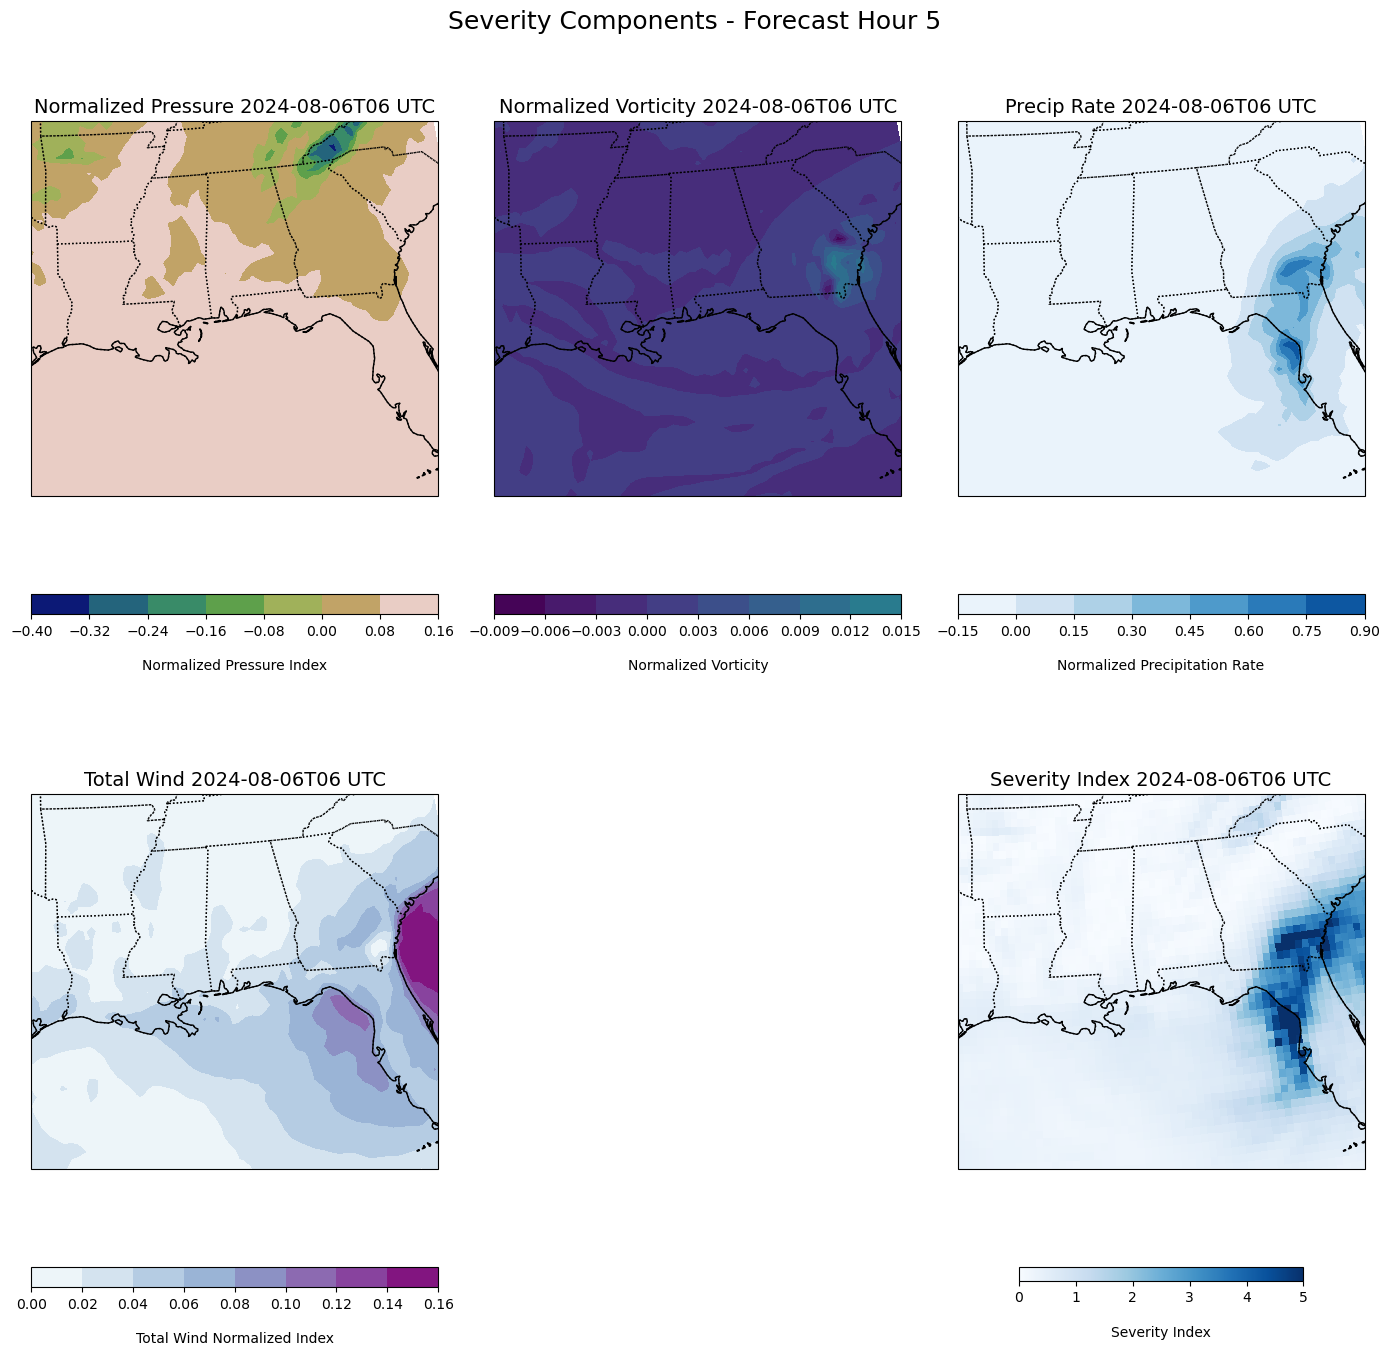

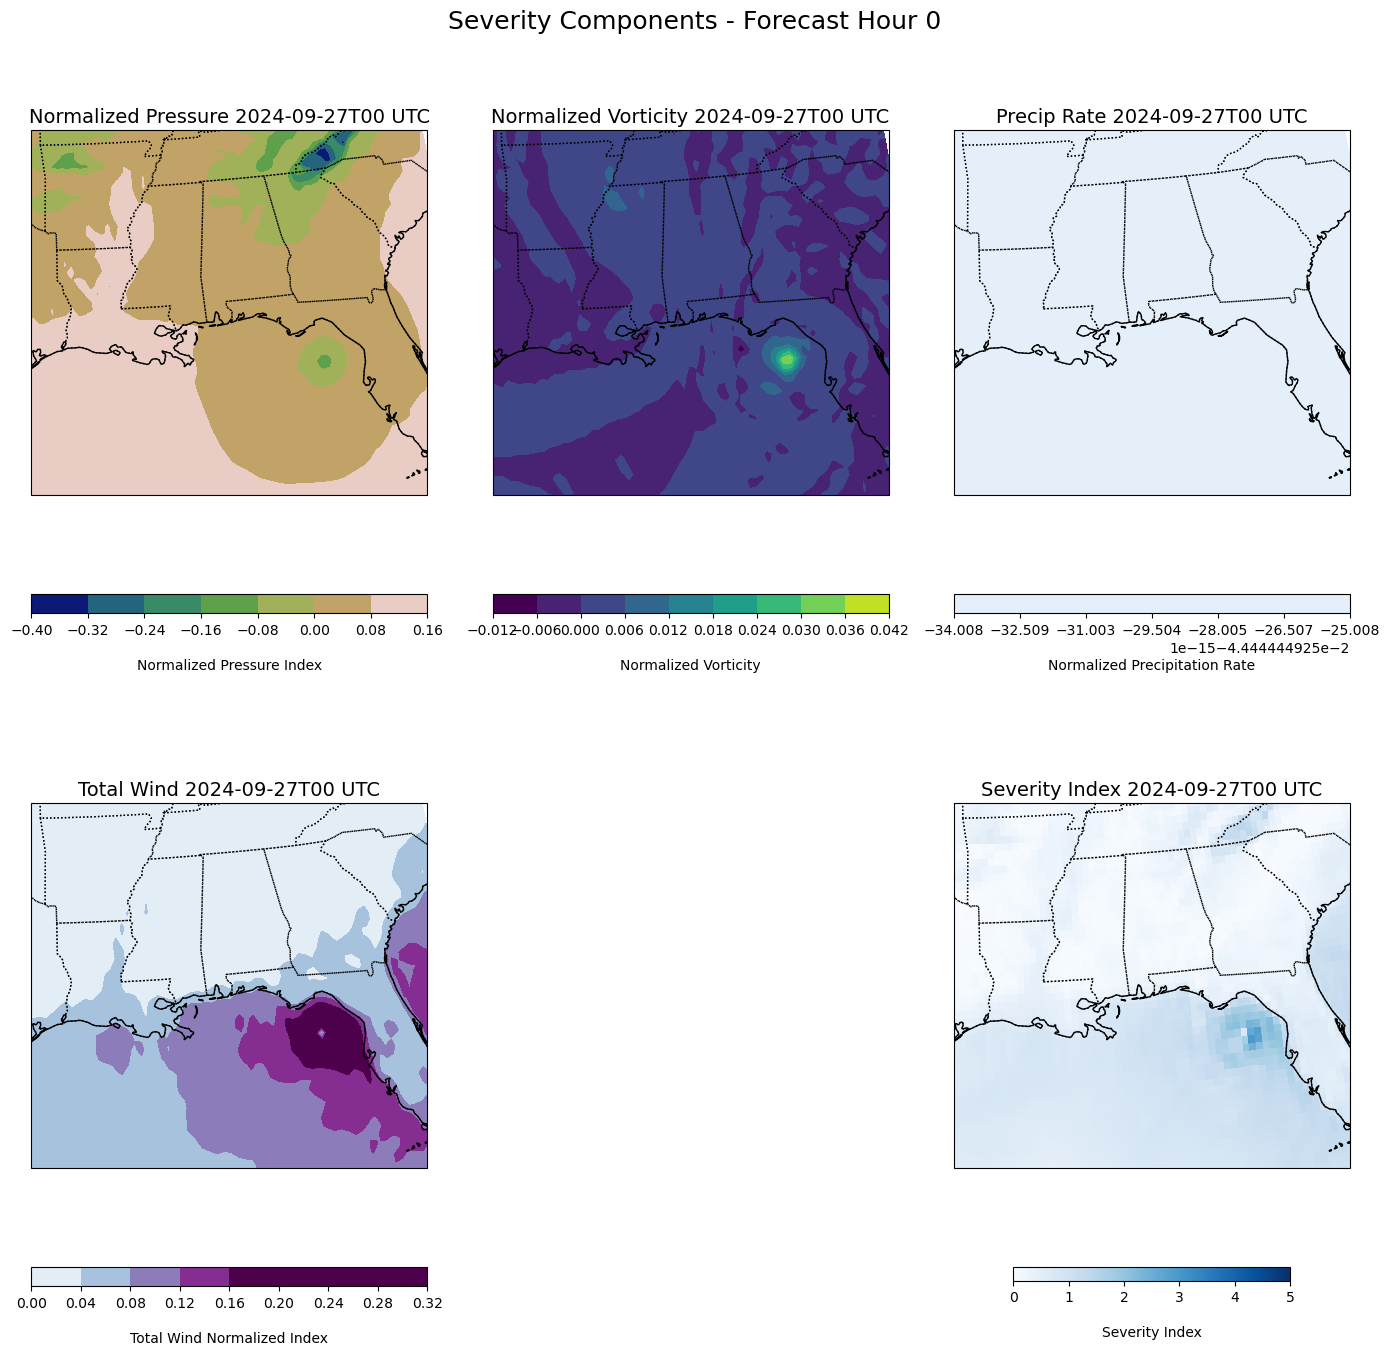

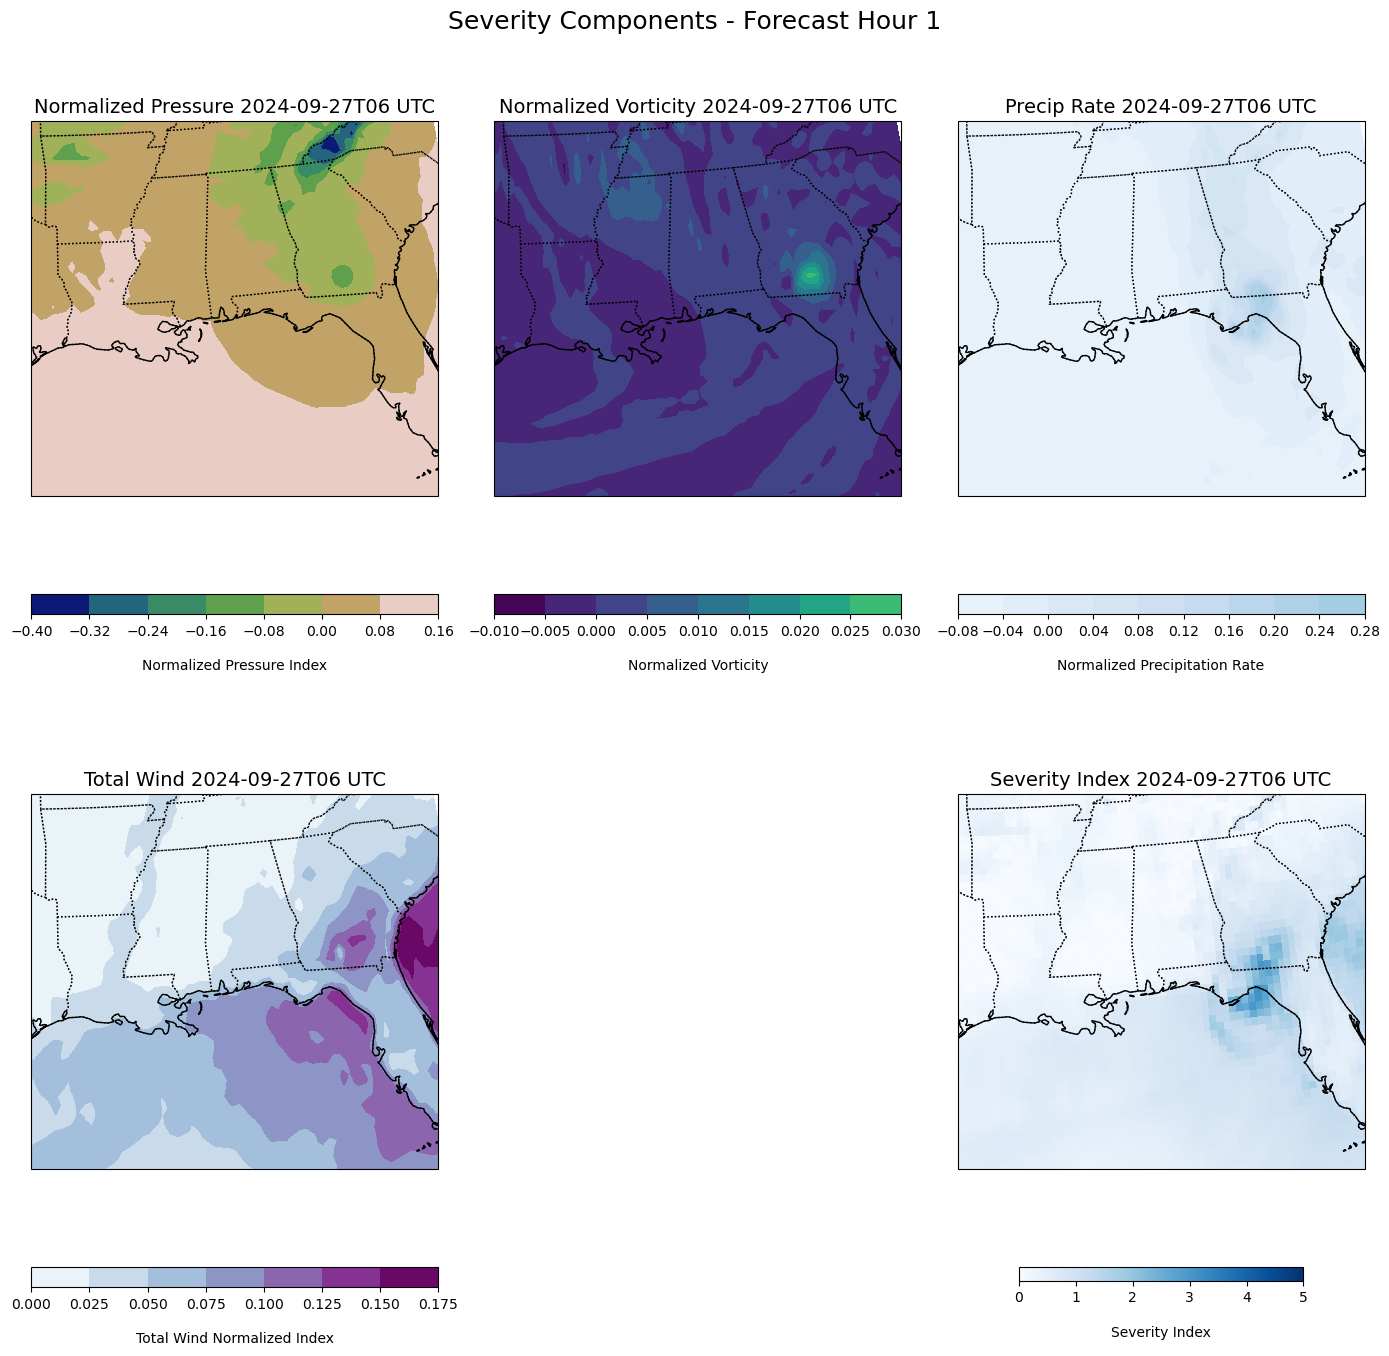

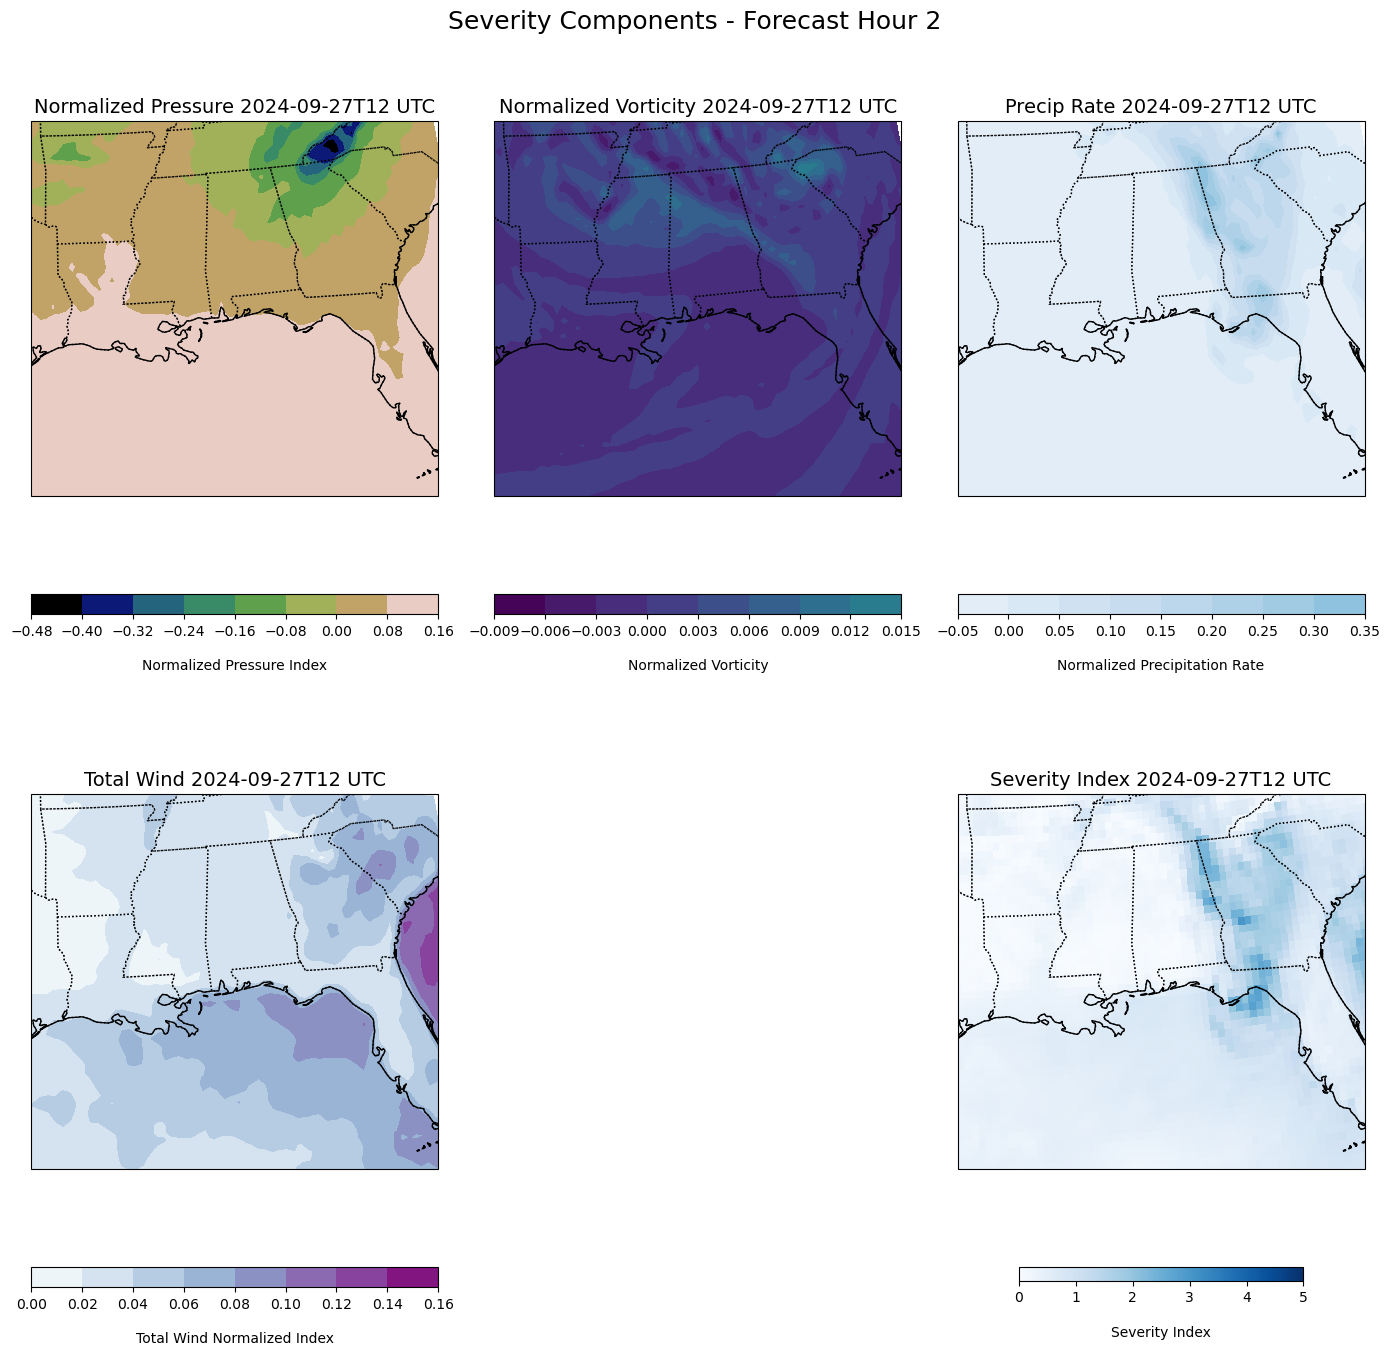

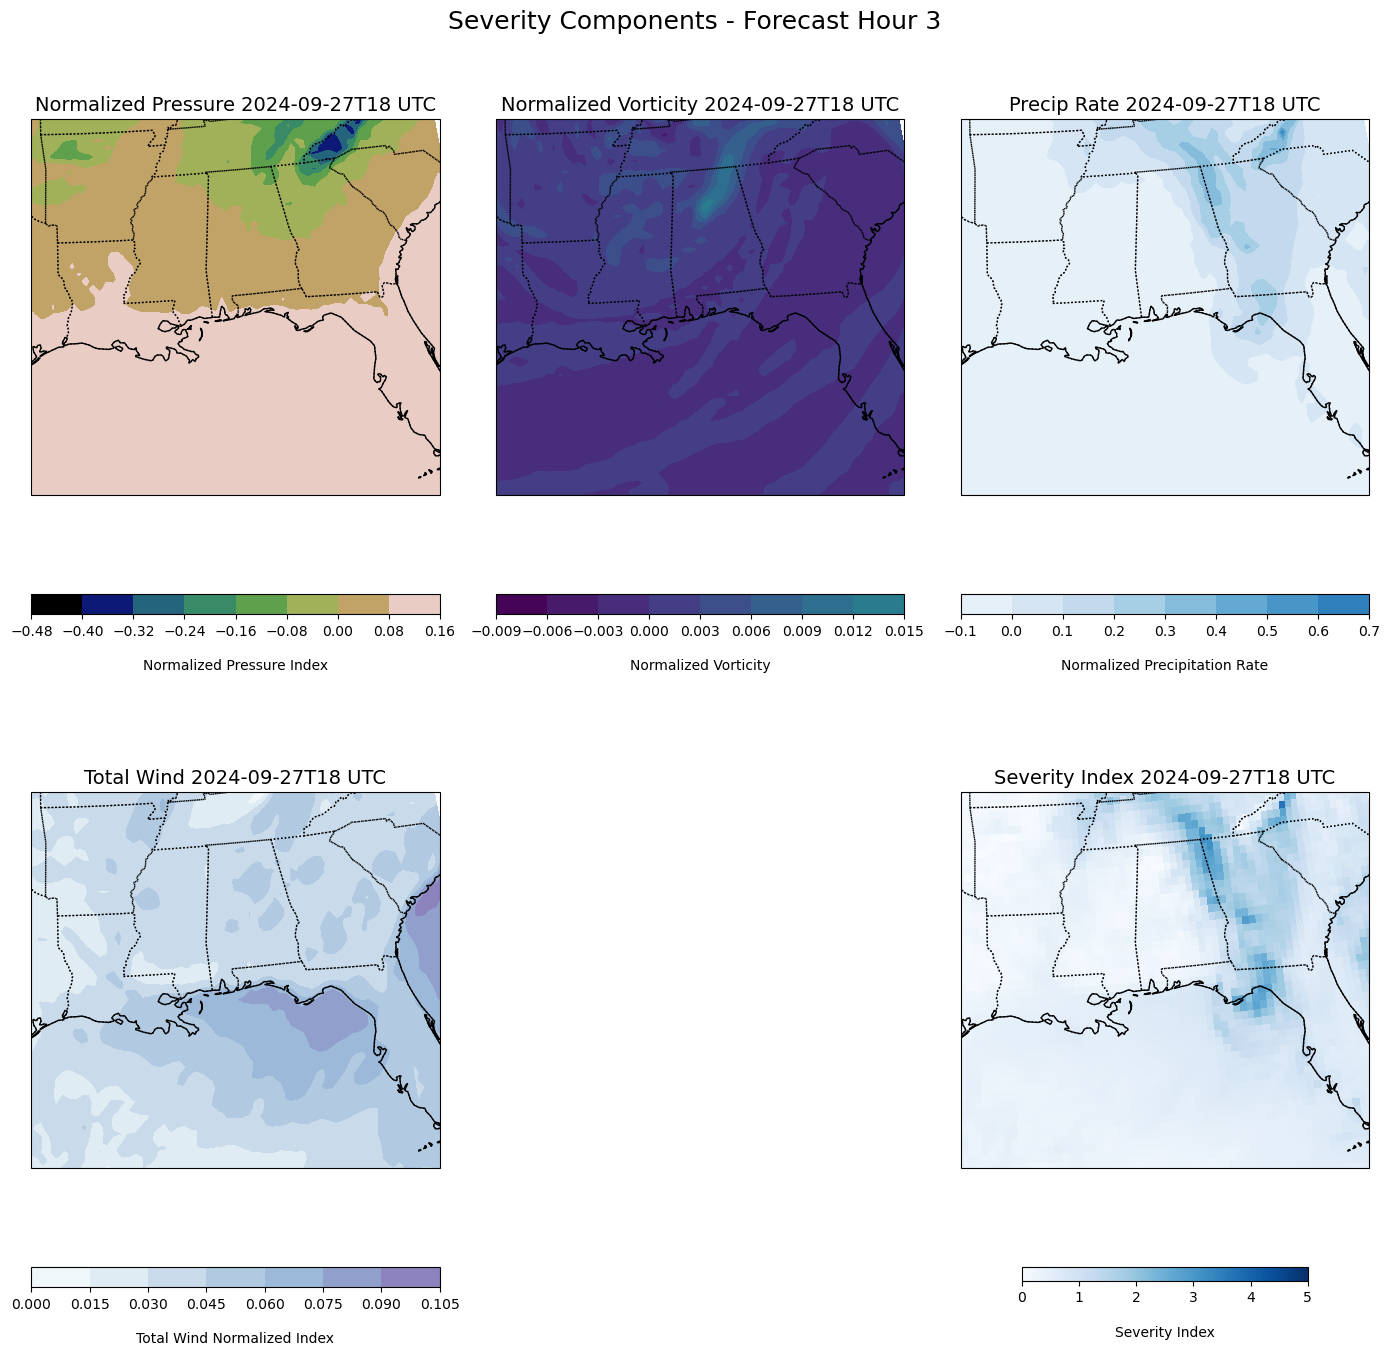

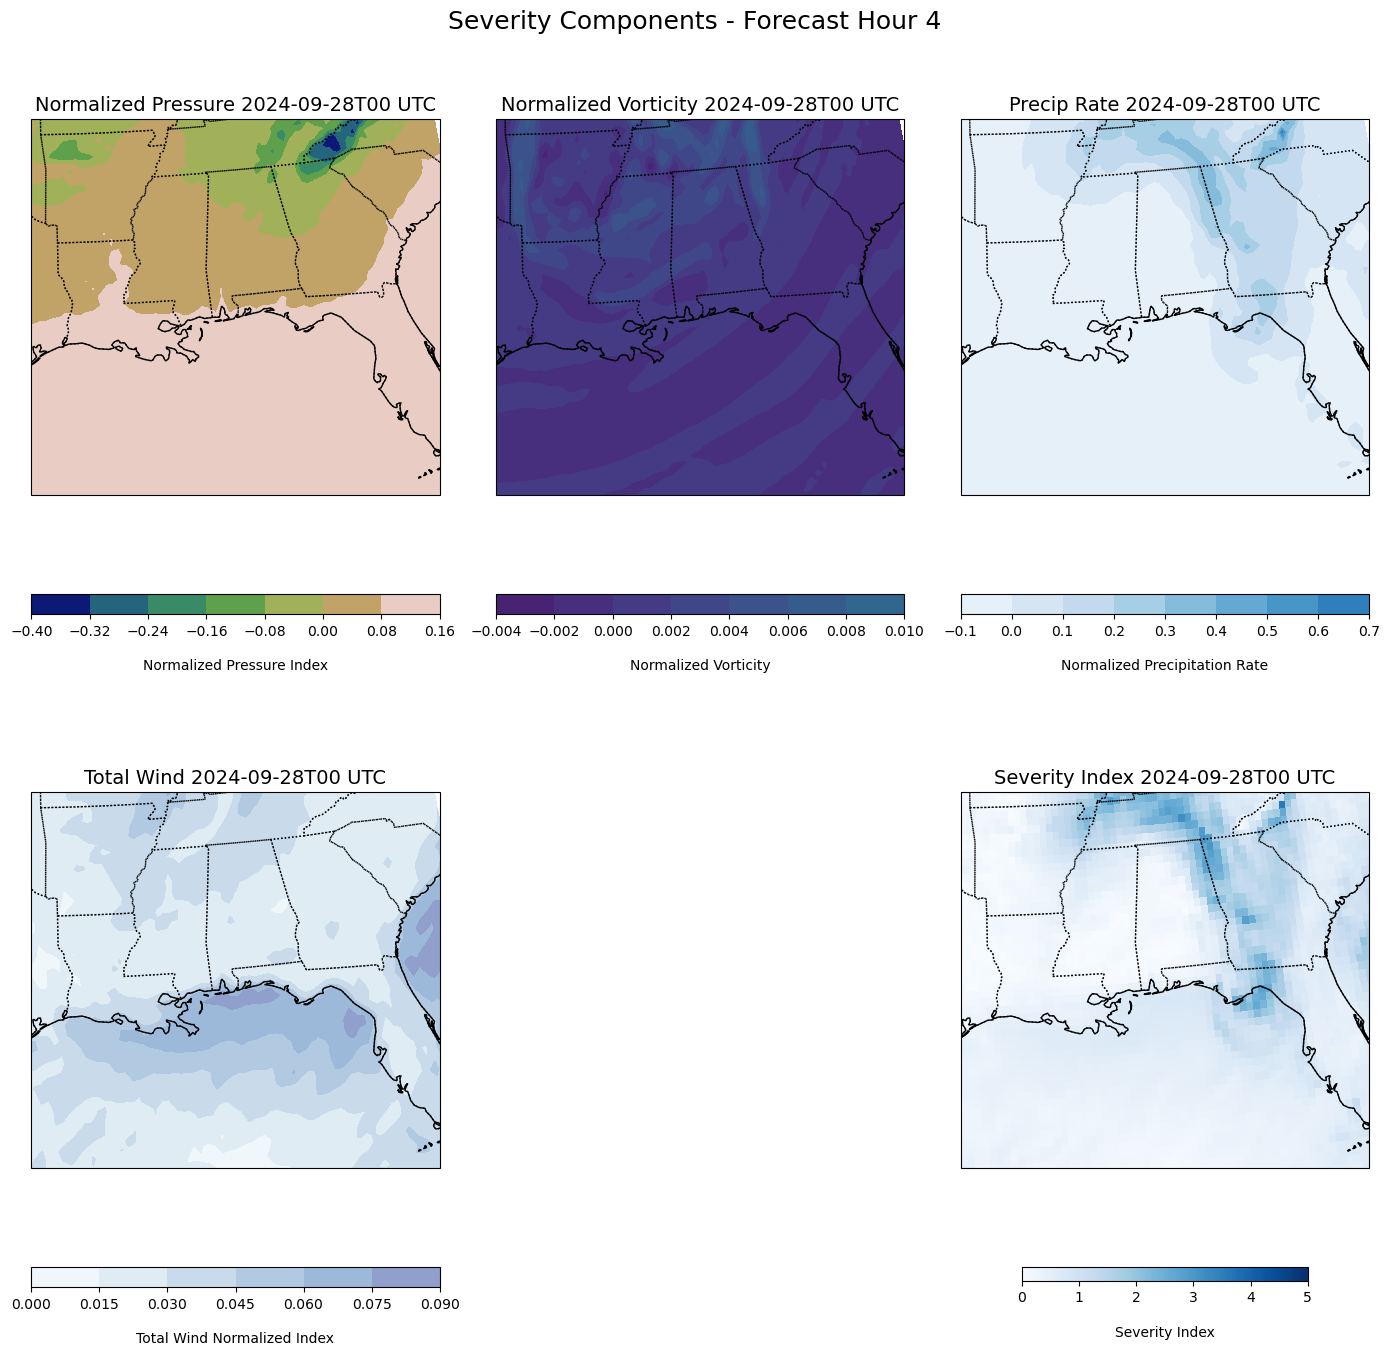

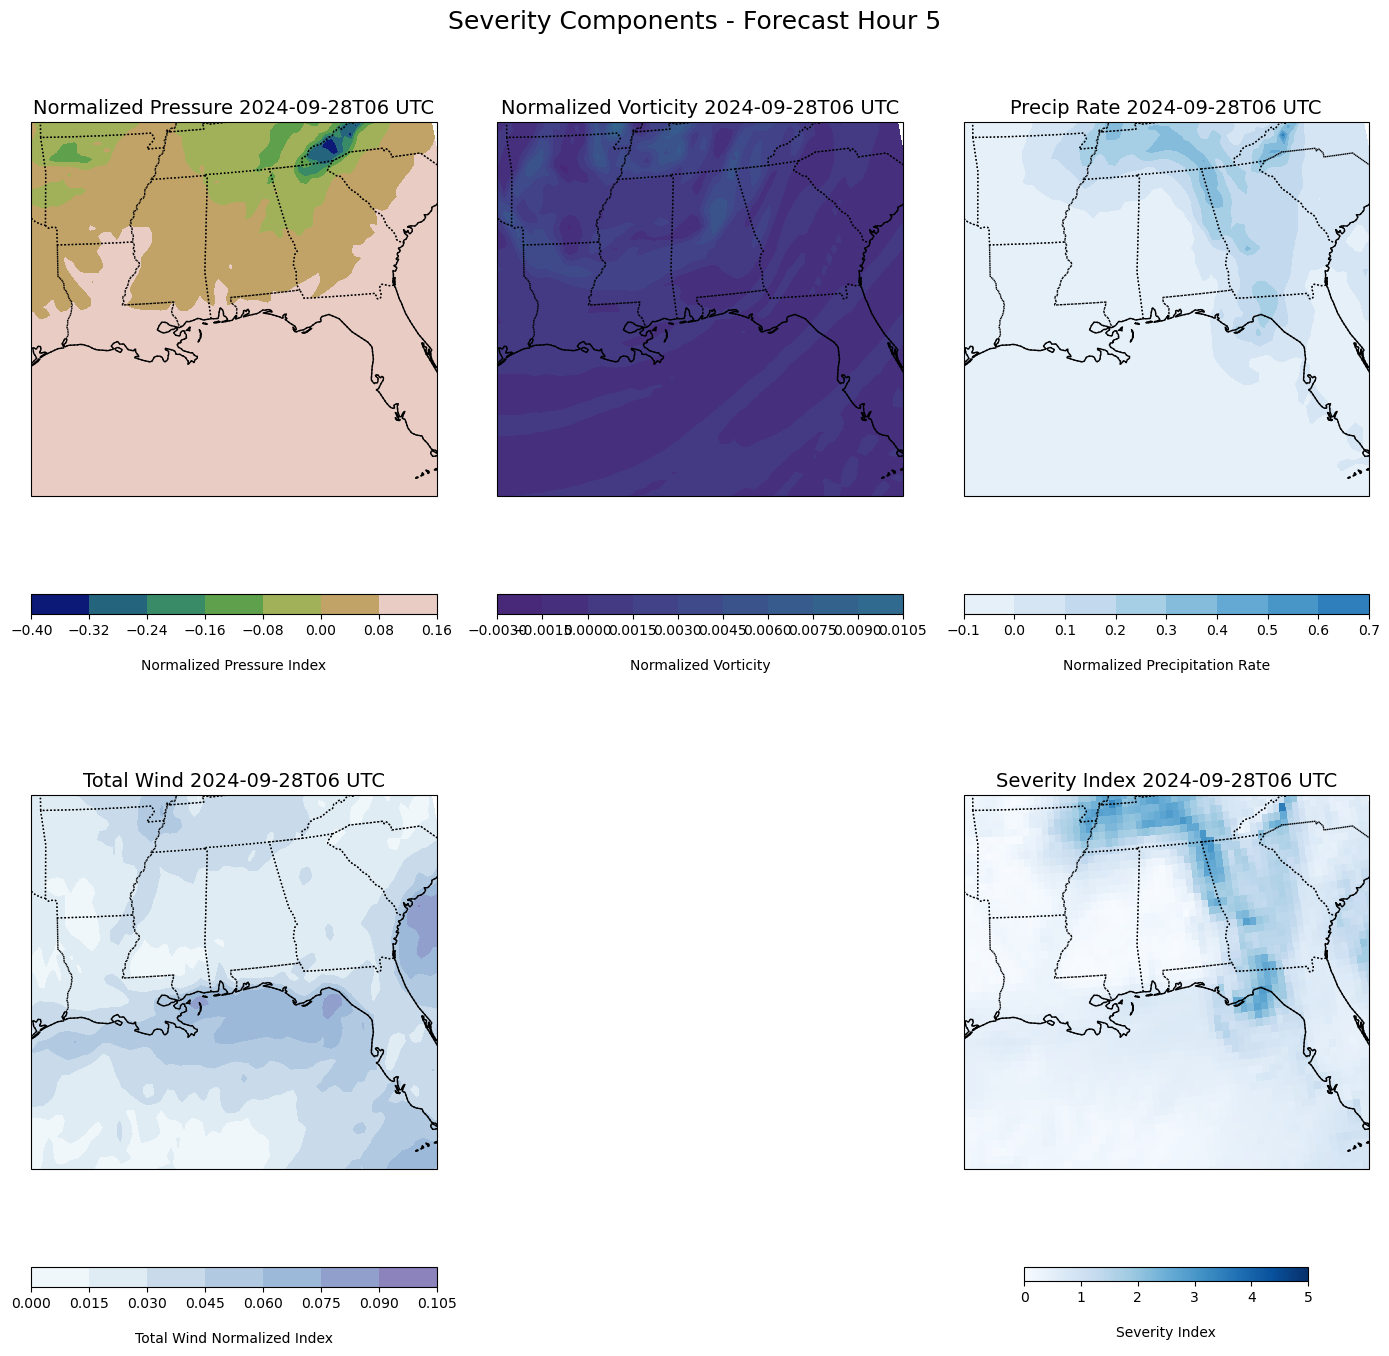

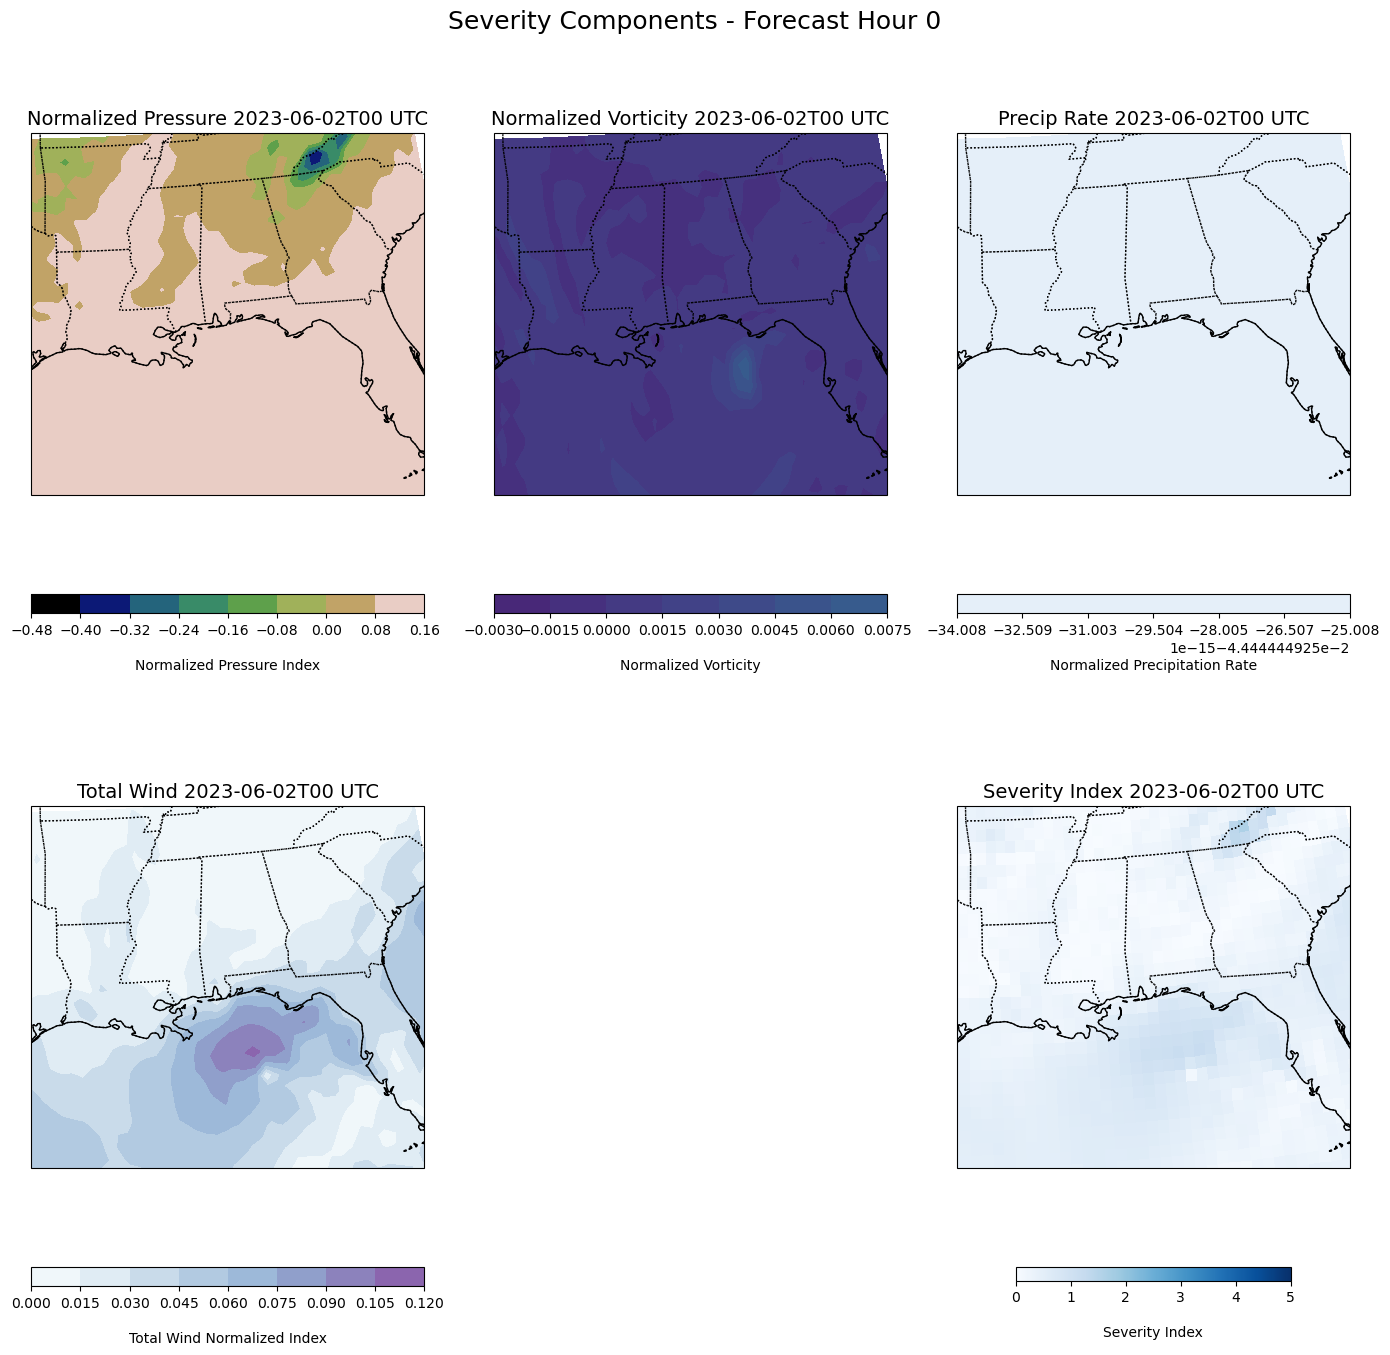

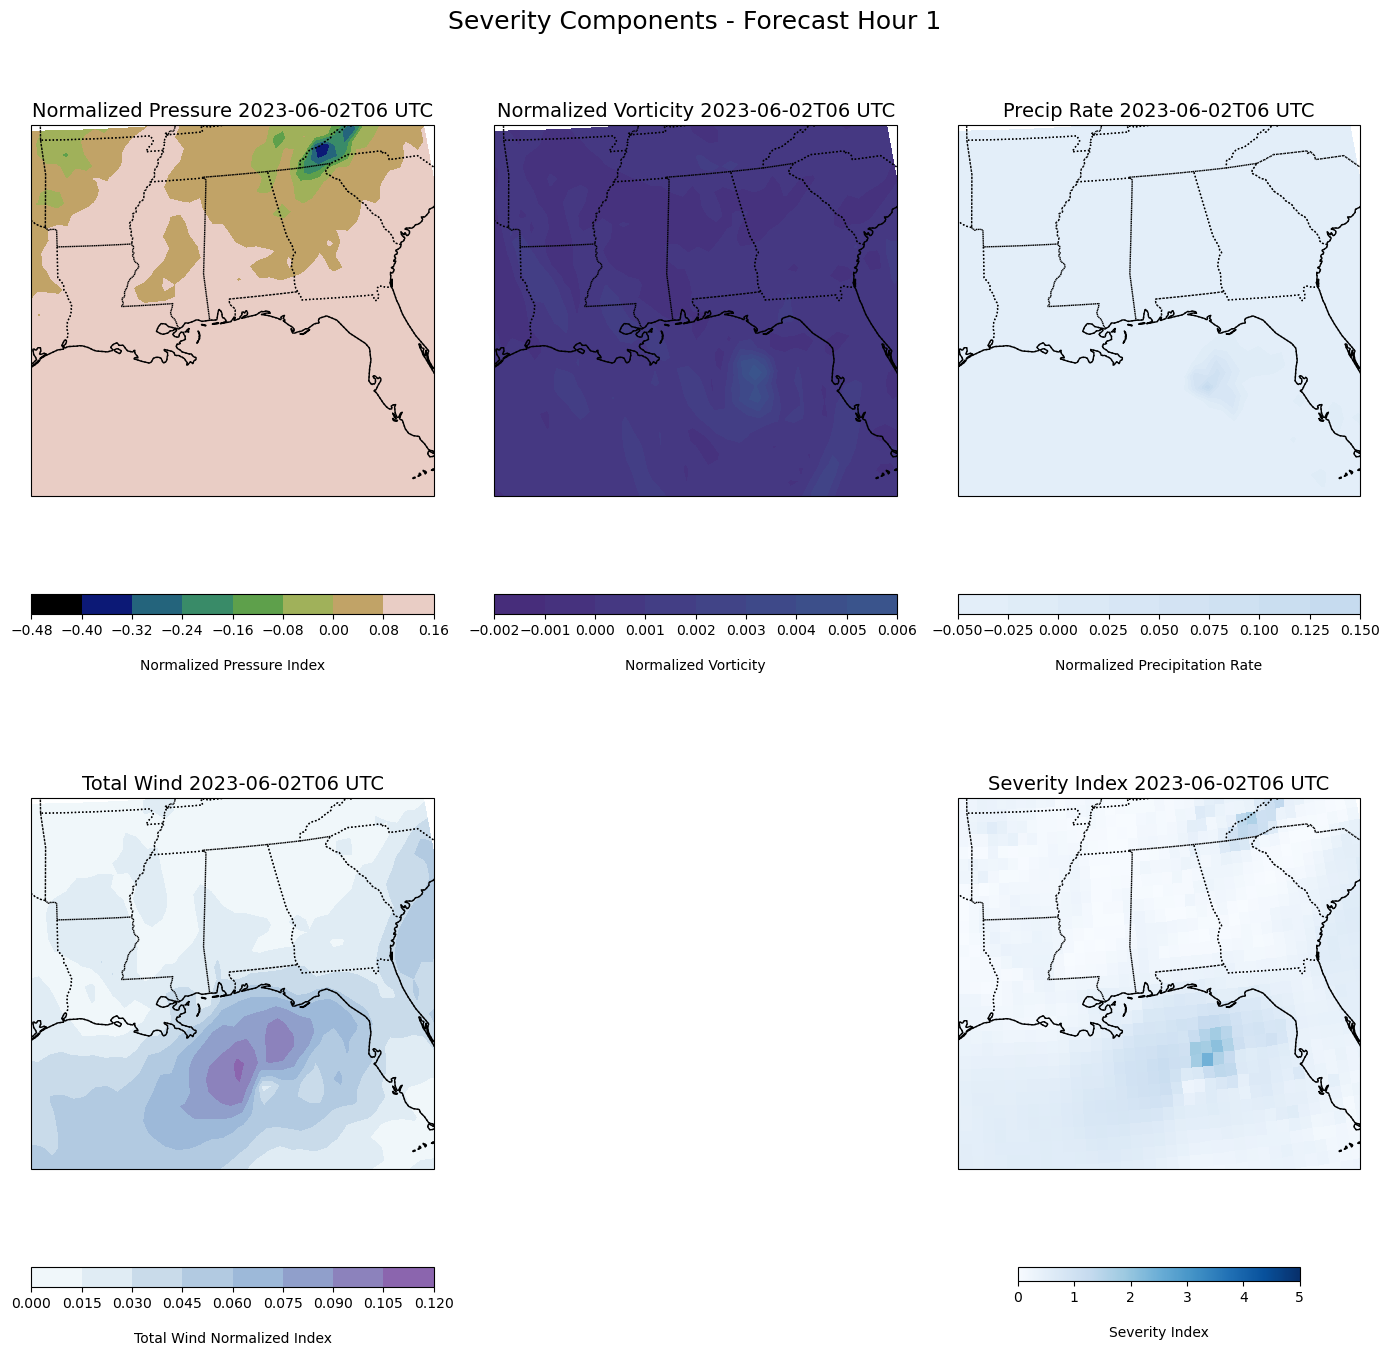

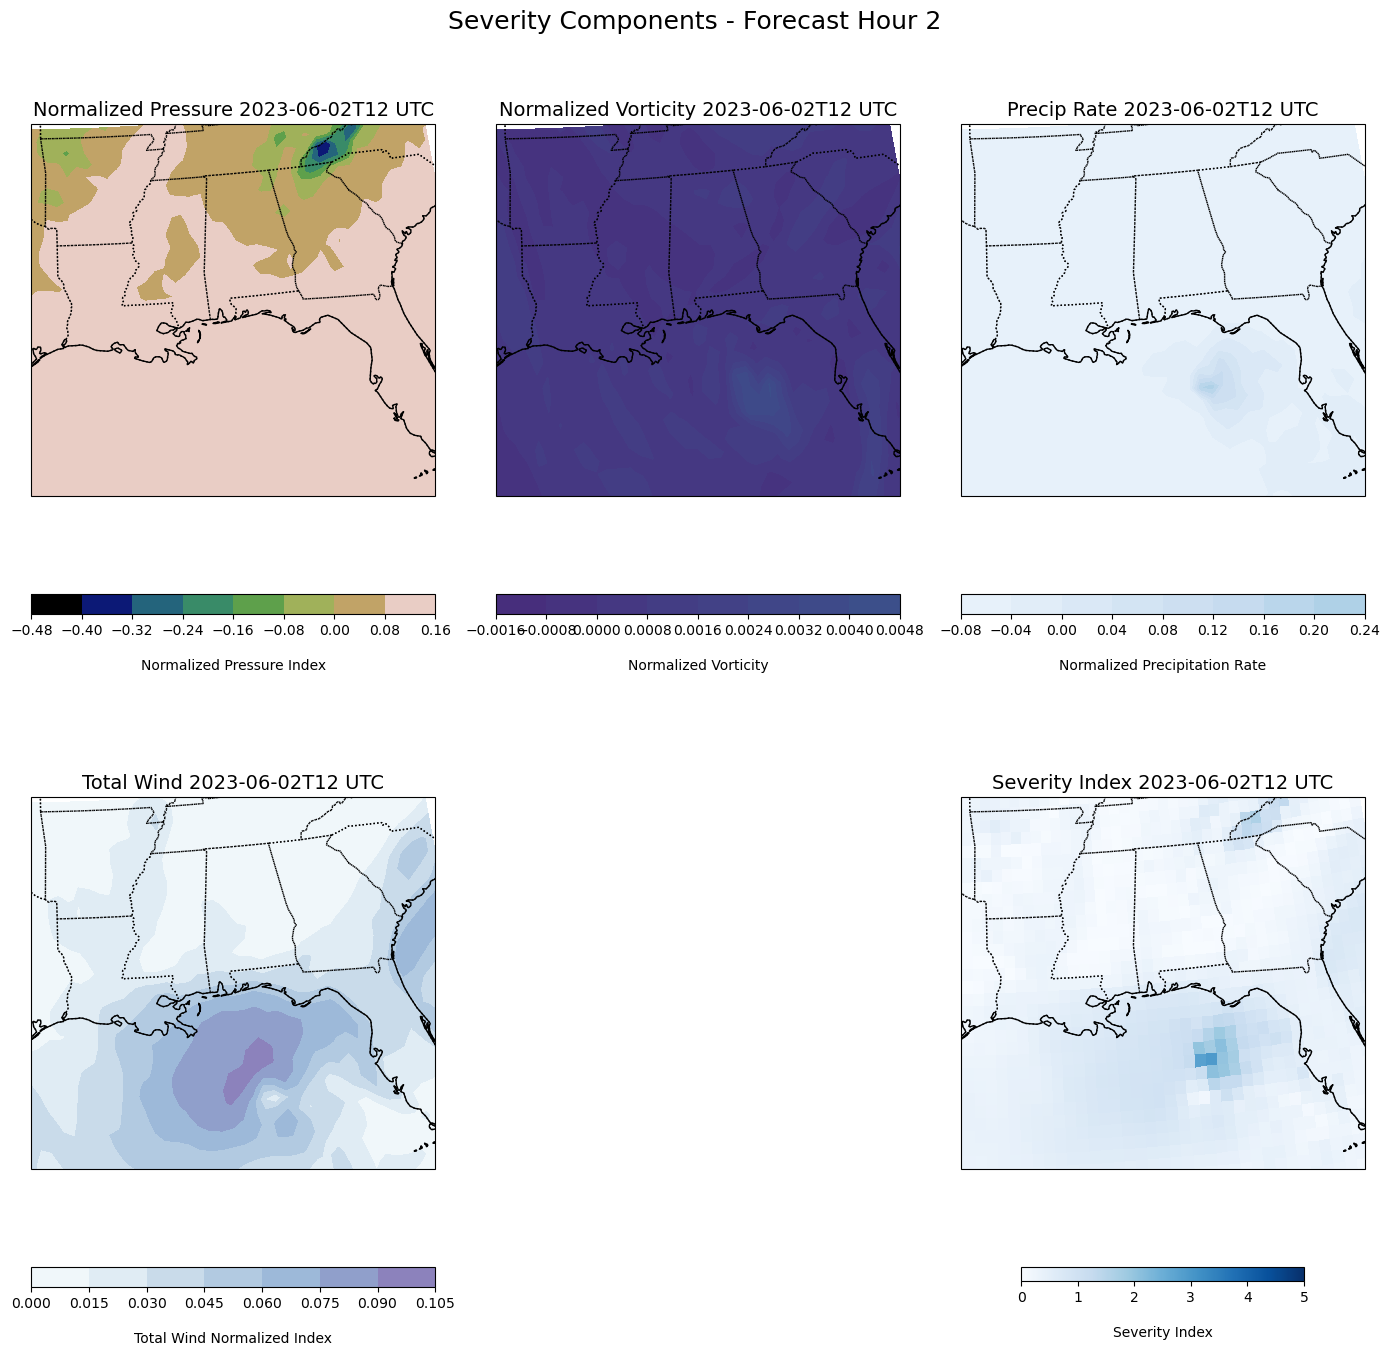

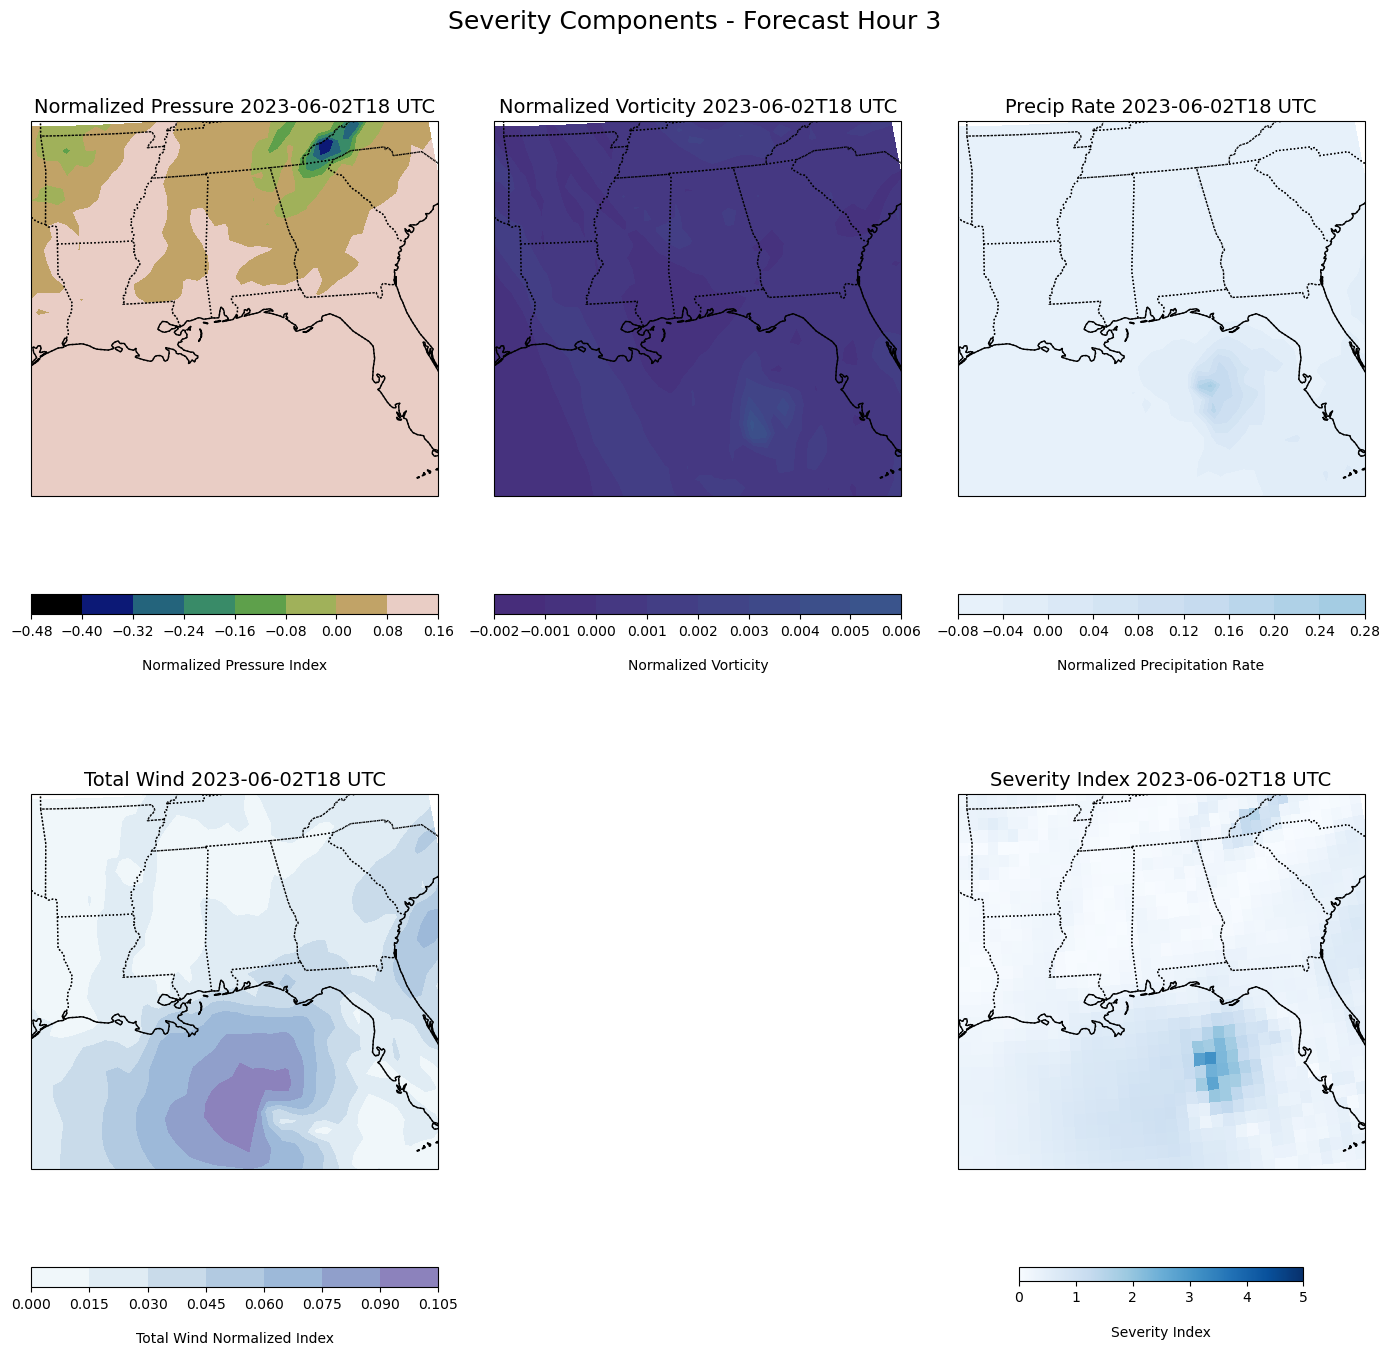

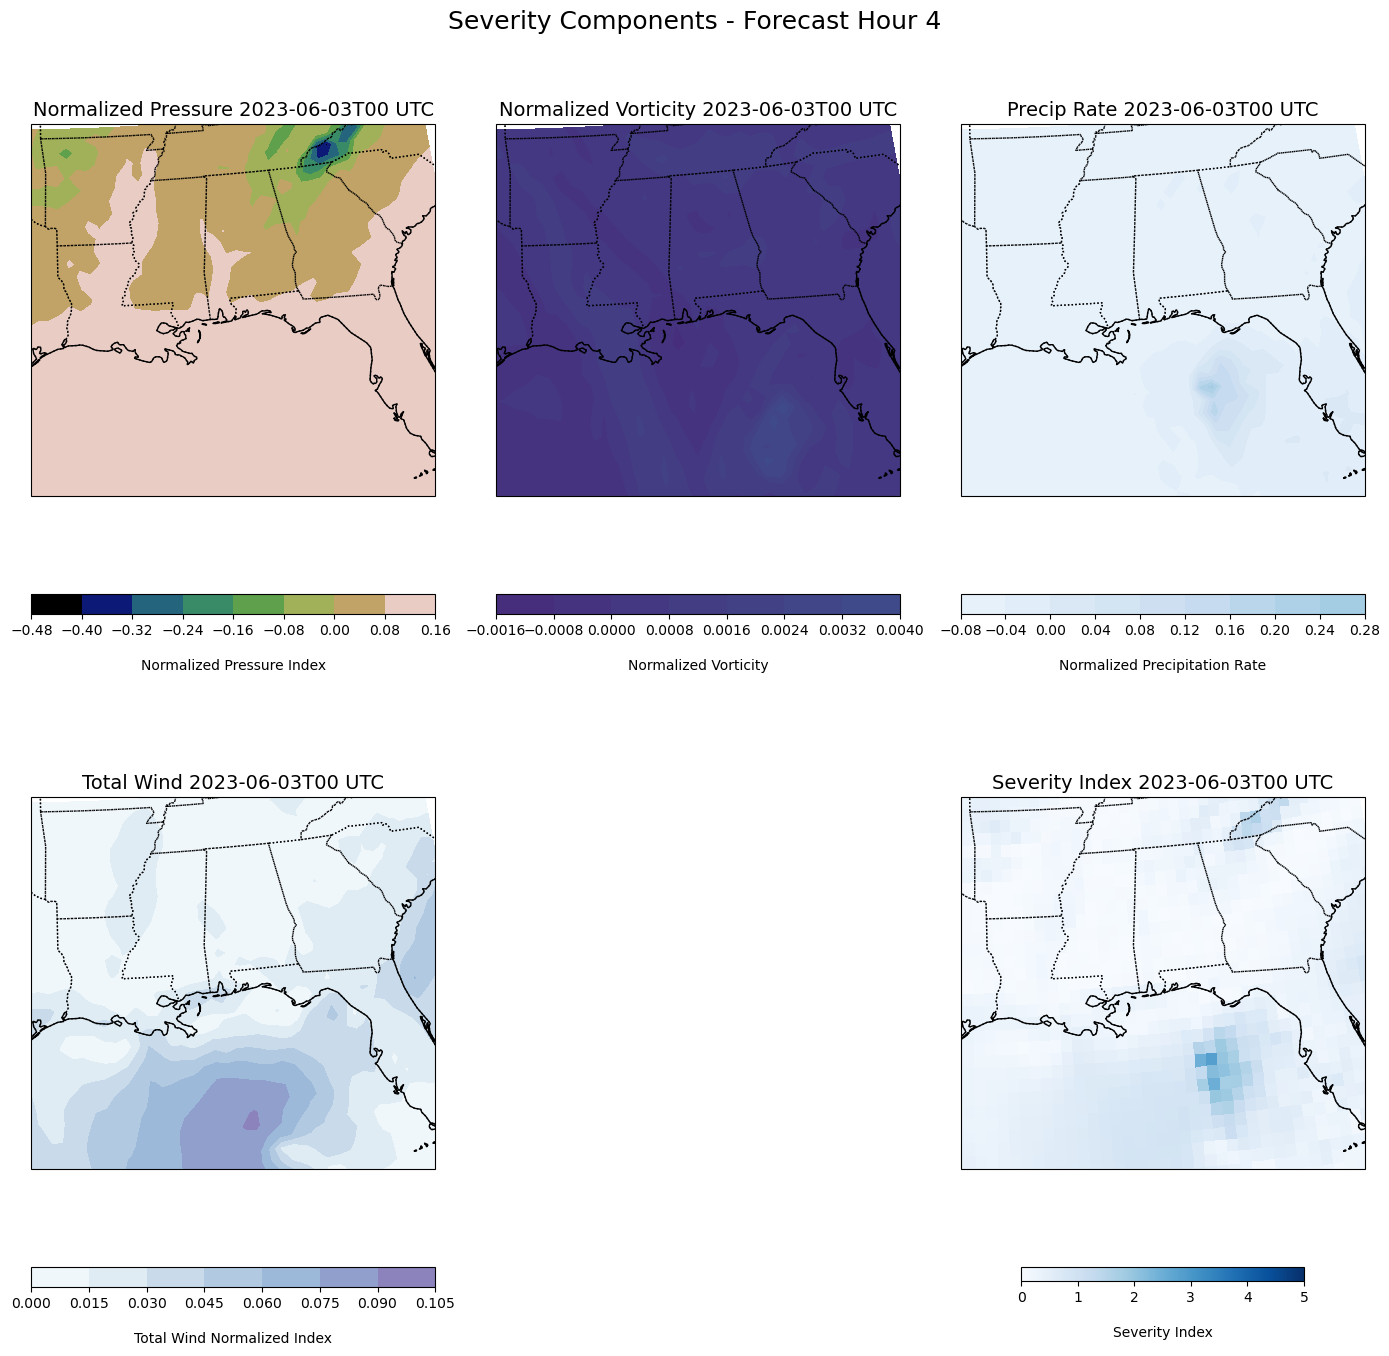

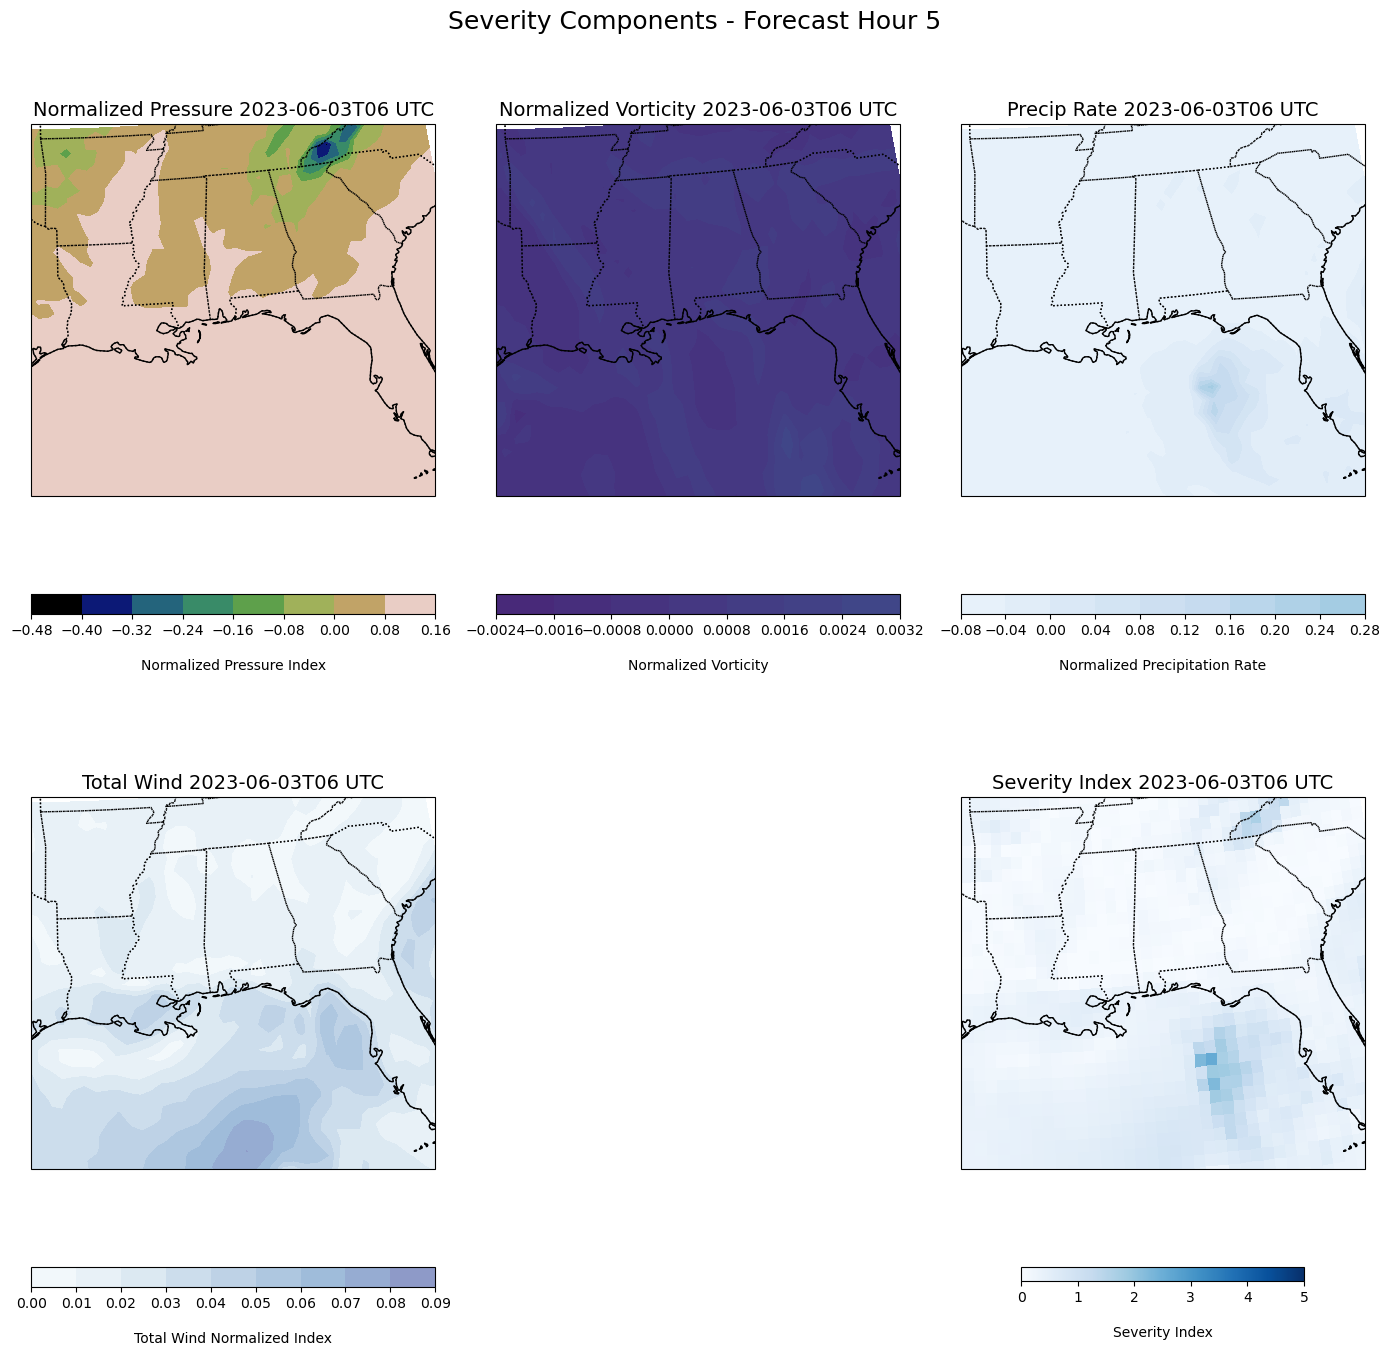

In [21]:
# Ellie and Landon
# initially we had the code copied and pasted five thousand times, now everything is reworked into functions and then just called below for the plots

# normalization of variables
def normalize(var, min_val, max_val): 
    return (var - min_val) / (max_val - min_val)

# function allowing for temperature conversions
def convert_temperature_to_kelvin(ds):
    t_units = ds['t'].attrs.get('units', 'K')
    if t_units == 'C':
        ds['t'] = ds['t'] + 273.15
        ds['t'].attrs['units'] = 'K'
    elif t_units == 'F':
        ds['t'] = (ds['t'] - 32) * (5 / 9) + 273.15
        ds['t'].attrs['units'] = 'K'
    return ds

# finding the pressure normalization 
def find_pressure(lst):
    sp = lst['sp'].values / 100
    pressure_norm = normalize(sp, 980, 1020)
    return pressure_norm

# finding the vorticity normalization
def find_vorticity(lst):
    vo = lst['vo'].sel(isobaricInhPa=500) 
    vorticity_norm = normalize(vo, -0.00001, 0.003)
    return vorticity_norm

# finding the precipitation rate normalization
def find_prate(lst):
    tp = lst['tp'].values
    approximatedprate = (tp * 39.37) / 6  # conversion to inches per hour (originally was in meters)
    prate_norm = normalize(approximatedprate, 0.1, 1.0)
    return prate_norm

# find wind normalization
def find_wind(lst):
    uNew = lst['u'].sel(isobaricInhPa=1000).values
    vNew = lst['v'].sel(isobaricInhPa=1000).values
    totalwind = ((uNew ** 2 + vNew ** 2) ** 0.5) * 2 # conversion to knots for easier plotting
    totalwind_norm = normalize(totalwind, 0, 140)
    return totalwind_norm
    
    
# threat function
def find_threat(lst):
     # pulling in the previously defined functions and use them on the inputted list
    pressure_norm = find_pressure(lst)
    vorticity_norm = find_vorticity(lst)
    totalwind_norm = find_wind(lst)
    prate_norm = find_prate(lst)

    # threat formula 
    severity_index = abs((0.5 * totalwind_norm) + (0.3 * prate_norm) + (0.15 * vorticity_norm) + (0.05 * pressure_norm))
    # weighted severity index, we decided to have it mostly based on total wind and precipitation, with small components of the vorticity and pressure for some more depth
    severity_index = severity_index * 10
    # multitplied our index by ten to make the values a little more " realistic " to have a range 1-5 instead of decimals
    return severity_index
    

# function for easier repeated plots

def plot_forcasted_six_hours(file_name):
    ogds = xr.open_dataset(file_name)
    ogds = ogds.sortby('valid_time')
    
    #allowing for unit conversions
    ogds = convert_temperature_to_kelvin(ogds)

    # Looping through the first 6 forecast hours (36 total hours)
    for i in range(6):
        ds = ogds.isel(valid_time=i)
        ds1 = ds.sel(longitude=slice(-97, -79), latitude=slice(37, 22))
        lat = ds1.latitude.values
        lon = ds1.longitude.values
        
        severity_index_adjust = find_threat(ds1)
        pressure_norm = find_pressure(ds1)
        vorticity_norm = find_vorticity(ds1)
        totalwind_norm = find_wind(ds1)
        prate_norm = find_prate(ds1)
        
        valid_time_str = np.datetime_as_string(ds.valid_time.values, unit='h')
        dataproj = ccrs.PlateCarree()
        fig = plt.figure(figsize=(14, 14))
    
        # Subplot 1: Pressure
        ax = fig.add_subplot(231, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.15 * pressure_norm, cmap='gist_earth', transform=dataproj, vmin = -0.4, vmax = 0.16) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Normalized Pressure Index', rotation=0, labelpad=15)
        ax.set_title(f'Normalized Pressure {valid_time_str} UTC', fontsize=14)
    
        # Subplot 2: Vorticity
        ax = fig.add_subplot(232, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.05 * vorticity_norm, cmap='viridis', transform=dataproj, vmin = -0.008, vmax = 0.044) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Normalized Vorticity', rotation=0, labelpad=15)
        ax.set_title(f'Normalized Vorticity {valid_time_str} UTC', fontsize=14)
    
        # Subplot 3: Precipitation Rate
        ax = fig.add_subplot(233, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.4 * prate_norm, cmap='Blues', transform=dataproj, vmin = -0.15, vmax = 1) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Normalized Precipitation Rate', rotation=0, labelpad=15)
        ax.set_title(f'Precip Rate {valid_time_str} UTC', fontsize=14)
    
        # Subplot 4: Wind
        ax = fig.add_subplot(234, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.5 * totalwind_norm, cmap='BuPu', transform=dataproj, vmin = 0 , vmax = 0.175) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Total Wind Normalized Index', rotation=0, labelpad=15)
        ax.set_title(f'Total Wind {valid_time_str} UTC', fontsize=14)
    
        # Subplot 5: Severity Index
        ax = fig.add_subplot(236, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        mesh = ax.pcolormesh(lon, lat, severity_index_adjust, cmap='Blues',
                         transform=dataproj, shading='auto')
        mesh.set_clim(0, 5) # standardized color bar for consistency
        
        cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', shrink=0.7)
        cbar.set_label('Severity Index', rotation=0, labelpad=15)
        ax.set_title(f'Severity Index {valid_time_str} UTC', fontsize=14)
    
        plt.suptitle(f'Severity Components - Forecast Hour {i}', fontsize=18)
        plt.tight_layout()
        plt.show()
        plt.close()

# original test case 08/05/2024
plot_forcasted_six_hours('meteo473ecmwf08052024t2.nc')

# additional high end test case 09/27/2024
plot_forcasted_six_hours('meteo473ecmwf09272024t2.nc')

# additional low end test case 06/02/2023
plot_forcasted_six_hours('meteo473ecmwf06022023t2.nc')
    


We tested the algorithm on three separate tropical events Hurricane Debby (Net CDF File named meteo473ecmwf08052024t2.nc for the full 0-246 run) as well as Hurricane Helene (09/27/2024), and Tropical Storm Arlene (06/02/2023) two high scale events nearly maxing out our index ( Major Hurricane events) as well as a lower scale event (Tropical Storm). Our alrgorithm did a pretty good job in evaluation of these events, highlighting the movement of the storms, showing how the damage index tracked accurately alongside the path of the respective storms. In terms of the damage index in of itself, particularly for the August 8th (Hurricane Debby) we have shifted our index to be from 0-5 instead of the 1-5 range we had initially developed. After testing it on multiple events and time steps. Our new index now is better described as 0-1 being minimal damage, 2-3 being moderate damage, and 4-5 being potential severe damage. The algorithm also highlights well the shifting of the total wind as the storm moves through,and is a large component of our algorithm. to confirm that our algoritm is evaluating strength of storm, our Tropical Storm run only produced maximum severity values in the 2-3 range, compared to the high end Hurricane runs producing values maxing out the index at 5.

In [22]:
# Ellie and Landon

# defining a function to do the entire model run plots 
def plot_index_over_240(file_name):
    ogds = xr.open_dataset(file_name)  # Load dataset
    ogds = ogds.sortby('valid_time')  # Sort by time

    proj = ccrs.LambertConformal()

    # Loop in batches of 6 forecast hours
    for batch_start in range(0, 36, 6):
        fig, axs = plt.subplots(
            nrows=2, ncols=3, figsize=(14, 12),  # smaller height
            subplot_kw={'projection': proj}
        )
        axs = axs.flatten()
        
        # batching plots into groups of six
        for idx in range(6):
            time_idx = batch_start + idx
            ds = ogds.isel(valid_time=time_idx)
            ds = ds.sel(longitude=slice(-97, -79), latitude=slice(37, 22))
            lat = ds.latitude.values
            lon = ds.longitude.values

            severity_index_adjust = find_threat(ds)

            valid_time_str = np.datetime_as_string(ds.valid_time.values, unit='h')

            ax = axs[idx]
            ax.set_extent([-95, -81, 36, 25], proj)
            ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
            ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
            ax.add_feature(cfeature.BORDERS.with_scale('50m'))

            mesh = ax.pcolormesh(lon, lat, severity_index_adjust, cmap='PuBuGn', transform=proj, shading='auto')
            mesh.set_clim(0, 5)
            ax.set_title(f'{valid_time_str} UTC', fontsize=10)

        # Colorbar
        cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # made thinner
        cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Severity Index (0–5)', fontsize=12)
        cbar.set_ticks([0, 1, 2, 3, 4, 5])

        # Titles and spacing
        plt.suptitle(f'Severity Index Forecasts | Hours {batch_start}–{batch_start + 5}', fontsize=16, y=0.97)
        fig.subplots_adjust(
            top=0.90, bottom=0.15, left=0.05, right=0.95,
            hspace=0.25, wspace=0.15  # tighter vertical (hspace) and horizontal (wspace) gaps
        )
        
        # Downloading the Plots a PNG
        plt.savefig(f'forecasthour{batch_start:03}.png')
        plt.close()

# running function with the selected model to generate plots
plot_index_over_240('meteo473ecmwf08052024t2.nc')
